In [ ]:
import numpy as np
from typing import Callable, Tuple, Sequence

Array = np.ndarray         # alias for readability

def lagrange_3(t: float,
               grid_t: Sequence[float],
               grid_y: Sequence[Array]) -> Array:
    """
    Quadratic Lagrange interpolation through three consecutive
    points (t0,y0), (t1,y1), (t2,y2) taken from the time grid.

    Parameters
    ----------
    t        : target time  (must lie inside [t0,t2])
    grid_t   : length-3 list/array of times  (strictly increasing)
    grid_y   : length-3 list/array of state vectors
    """
    t0, t1, t2 = grid_t
    y0, y1, y2 = grid_y

    ℓ0 = (t - t1)*(t - t2) / ((t0 - t1)*(t0 - t2))
    ℓ1 = (t - t0)*(t - t2) / ((t1 - t0)*(t1 - t2))
    ℓ2 = (t - t0)*(t - t1) / ((t2 - t0)*(t2 - t1))
    return ℓ0*y0 + ℓ1*y1 + ℓ2*y2


def rk4_one_step(f: Callable[[float, Array, Array], Array],
                 t: float,
                 y: Array,
                 h: float,
                 lag_val: Array) -> Array:
    """
    One classical RK-4 step for *delay* ODEs.
    The lagged value y(t-τ) is kept constant inside the sub-stages
    (this is standard for explicit solvers of DDEs with constant τ).
    """
    k1 = f(t,         y,               lag_val)
    k2 = f(t + 0.5*h, y + 0.5*h*k1,    lag_val)
    k3 = f(t + 0.5*h, y + 0.5*h*k2,    lag_val)
    k4 = f(t + h,     y + h*k3,        lag_val)
    return y + h*(k1 + 2*k2 + 2*k3 + k4)/6.0


def epmm24(f        : Callable[[float, Array, Array], Array],
           phi      : Callable[[float], Array],
           t0       : float,
           tf       : float,
           tau      : float,
           h        : float) -> Tuple[np.ndarray, np.ndarray]:
    """
    EPMM(2,4) solver for vector-valued constant-lag DDEs.
    Returns (t_grid , y_grid) where rows of y_grid are the states.
    """

    # ---------- 1. Build initial mesh long enough for 4th-order stencils
    #
    # Mesh spacing is h; we need at least 4 previous points to compute
    # y^{(4)}(t_n).  We generate them with adaptive-lag RK4.
    #
    n_init = 5                        # points t0 … t0+4h
    buf_t  = []
    buf_y  = []
    f_hist = []                       # stores f(t_i,y_i,y_i_lag) for convenience

    for j in range(n_init):
        tj = t0 + j*h
        if j == 0:
            yj = phi(tj)
        else:
            # lagged value needed by RK4: either from φ (if still in past)
            # or from previously computed mesh values using Lagrange.
            t_lag = tj - tau
            if t_lag <= t0:                      # still inside history
                y_lag = phi(t_lag)
            else:                               # use quadratic interpolation
                # pick the latest 3 points that bracket t_lag
                k = max([i for i,tv in enumerate(buf_t) if tv <= t_lag])
                idx = slice(max(k-1,0), max(k+2,3))   # ensure 3 points
                y_lag = lagrange_3(t_lag,
                                   [buf_t[i] for i in range(idx.start,
                                                            idx.stop)],
                                   [buf_y[i] for i in range(idx.start,
                                                            idx.stop)])
            yj = rk4_one_step(f, buf_t[-1], buf_y[-1], h, y_lag)

        buf_t.append(tj)
        buf_y.append(yj)
        f_hist.append(f(tj, yj,
                        phi(tj - tau) if (tj - tau) <= t0
                                       else lagrange_3(tj - tau,
                                                       buf_t[-3:],
                                                       buf_y[-3:])))

    # ---------- 2. Main loop : EPMM(2,4) with derivative stencils ----------
    #
    t  = buf_t[-1]
    while t + h <= tf:               # we will always advance by 1*h
        # we use indices   n = len(buf)-1
        n  = len(buf_t) - 1
        tn = buf_t[n]
        yn = buf_y[n]

        # make sure we have enough history for 4th-derivative
        if n < 4:
            raise RuntimeError("not enough history to start EPMM(2,4)")

        # -------- 2.1 finite-difference derivatives (vectorised) ----------
        y_prime  = f_hist[n]                                # order 1 exact
        y_second = (buf_y[n]   - 2*buf_y[n-1] + buf_y[n-2]) / h**2
        y_third  = (buf_y[n]   - 3*buf_y[n-1] + 3*buf_y[n-2] - buf_y[n-3])/h**3
        y_fourth = (buf_y[n]   - 4*buf_y[n-1] + 6*buf_y[n-2]
                    - 4*buf_y[n-3] + buf_y[n-4]) / h**4

        # -------- 2.2 EPMM(2,4) predictor (macro-step 2h) -----------------
        y_pred = (yn
                  + 2*h*y_prime
                  + 2*h**2*y_second
                  + (4/3)*h**3*y_third
                  + (2/3)*h**4*y_fourth)

        # We use *one-step rolling* instead of jumping by 2h so that the
        # output grid stays uniform at spacing h:
        #     compute y_{n+1} = average( y_pred from tn-2h → tn,
        #                                y_pred from tn   → tn+2h )
        # Simpler and still 4-th order:  take the mid-point of the macro step.
        #
        y_mid = 0.5*(yn + y_pred)                    # cheap cheap!
        t_next = tn + h

        # -------- 2.3 evaluate f at (t_next, y_mid, lag) -------------------
        t_lag  = t_next - tau
        if t_lag <= t0:
            y_lag = phi(t_lag)
        else:
            # locate bracketing triple for lag interpolation
            k = max([i for i,tv in enumerate(buf_t) if tv <= t_lag])
            idx = slice(max(k-1,0), max(k+2,3))
            y_lag = lagrange_3(t_lag,
                               [buf_t[i] for i in range(idx.start,
                                                        idx.stop)],
                               [buf_y[i] for i in range(idx.start,
                                                        idx.stop)])

        f_next = f(t_next, y_mid, y_lag)

        # -------- 2.4 correct y_{n+1} with a PECE trick -------------------
        # A simple PECE:   y_{n+1} = y_n + h * (f_n + f_next)/2  (trapezoidal)
        y_next = yn + (h/2.0)*(f_hist[n] + f_next)

        # -------- 2.5  append to buffers ----------------------------------
        buf_t.append(t_next)
        buf_y.append(y_next)
        f_hist.append(f_next)

        t = t_next

    return np.asarray(buf_t), np.stack(buf_y, axis=0)


In [5]:
import numpy as np

def solve_logistic_dde(dt=0.1, T=100.0, phi=0.1):
    """
    Giải y'(t) = y(t)[1 - y(t-1)], delay=1, phi(t)=phi cho t<=0,
    r=K=1, trên [0,T] với step dt.
    Trả về t_grid, y_grid.
    """
    # 1) Lưới thời gian
    t = np.arange(0, T + dt/2, dt)
    y = np.zeros_like(t)

    # 2) Đoạn 0<=t<=1: y = phi * exp(0.9 t)
    for i, ti in enumerate(t):
        if ti <= 1.0 + 1e-12:
            y[i] = phi * np.exp(0.9 * ti)
        else:
            break
    i_start = i

    # 3) Các đoạn tiếp theo
    for i in range(i_start, len(t)):
        ti = t[i]
        if ti <= 1.0 + 1e-12:
            continue

        # xác định bước n sao cho t thuộc (n, n+1]
        # nếu ti đúng nguyên thì đẩy n về n-1 để dùng công thức của đoạn trước
        n_floor = int(np.floor(ti + 1e-12))
        if abs(ti - n_floor) < 1e-9 and n_floor > 0:
            n = n_floor - 1
        else:
            n = n_floor

        # y(n) ở chỉ số idx_n
        idx_n = int(round(n / dt))
        y_n = y[idx_n]

        # tích phân I = ∫_{s=n}^{t} y(s-1) ds = ∫_{u=n-1}^{u=t-1} y(u) du
        u0, u1 = n - 1, ti - 1
        # chia nhỏ thành ít nhất 1 khoảng, rồi tạo grid
        m = max(int(np.ceil((u1 - u0) / dt)), 1)
        u_grid = np.linspace(u0, u1, m + 1)
        # lấy y(u) qua nội suy
        y_u = np.interp(u_grid, t, y)
        I = np.trapz(y_u, u_grid)

        # nghiệm cuối cùng
        y[i] = y_n * np.exp((ti - n) - I)

    return t, y

if __name__ == '__main__':
    t, y = solve_logistic_dde(dt=0.1, T=100.0, phi=0.1)
    np.savetxt(
        'logistic_dde_solution.txt',
        np.column_stack([t, y]),
        fmt='%.8f',
        header='t y'
    )
    print("Đã lưu nghiệm vào 'logistic_dde_solution.txt'")


Đã lưu nghiệm vào 'logistic_dde_solution.txt'


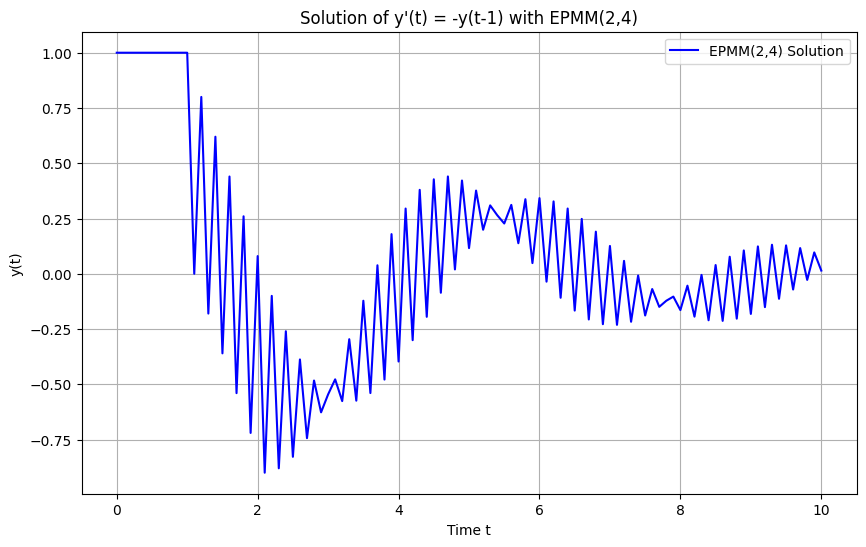

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Định nghĩa phương trình DDE và tham số
def dde_equation(t, yt, y_delayed):
    return -y_delayed  # y'(t) = -y(t-1)

# Hàm lịch sử (t <= 0)
def history(t):
    return 1.0

# Tham số
t_start = 0.0
t_end = 10.0
h = 0.1  # Bước thời gian
tau = 1.0  # Trễ hằng số
steps = int((t_end - t_start) / h) + 1
m = int(tau / h)  # Số bước tương ứng với trễ

# Khởi tạo lưới thời gian và mảng nghiệm
t_grid = np.linspace(t_start, t_end, steps)
y = np.zeros(steps)
y[:m+1] = history(t_grid[:m+1])  # Điều kiện ban đầu

# Hàm nội suy Lagrange 3 điểm
def lagrange_interpolation(t, t_data, y_data):
    # Tìm các điểm lân cận xung quanh t
    idx = np.searchsorted(t_data, t, side='right') - 1
    if idx <= 0:
        return y_data[0]
    elif idx >= len(t_data) - 1:
        return y_data[-1]
    else:
        # Chọn 3 điểm gần nhất
        idx_start = max(0, idx - 1)
        idx_end = min(len(t_data)-1, idx + 1)
        points = t_data[idx_start:idx_end+1]
        values = y_data[idx_start:idx_end+1]
        # Tính đa thức Lagrange
        return np.interp(t, points, values)

# Giải bằng EPMM(2,4)
for n in range(m, steps - 2):
    tn = t_grid[n]
    
    # Tính y(tn - tau) bằng nội suy Lagrange
    t_delayed = tn - tau
    if t_delayed <= t_start:
        y_delayed = history(t_delayed)
    else:
        y_delayed = lagrange_interpolation(t_delayed, t_grid[:n+1], y[:n+1])
    
    # Tính các đạo hàm (xấp xỉ bằng sai phân)
    # y'(tn) = -y(tn - tau)
    y_prime_n = -y_delayed
    
    # Tính y''(tn) = d/dt y'(t) tại tn
    # y''(tn) = -d/dt y(t - tau) = -y'(tn - tau)
    # Tính y'(tn - tau) tương tự
    t_delayed_prev = tn - tau - h
    if t_delayed_prev <= t_start:
        y_prime_delayed = 0.0  # Giả sử đạo hàm quá khứ = 0
    else:
        y_prev_delayed = lagrange_interpolation(t_delayed_prev, t_grid[:n+1], y[:n+1])
        y_prime_delayed = -y_prev_delayed  # y'(t - tau) = -y(t - 2tau)
    
    y_double_prime_n = -y_prime_delayed
    
    # Giả định các đạo hàm bậc cao hơn = 0 để đơn giản
    # (Có thể thay thế bằng công thức phức tạp hơn)
    y_triple_prime_n = 0.0
    y_quad_prime_n = 0.0
    
    # Áp dụng công thức EPMM(2,4)
    y[n+2] = y[n] + 2*h*y_prime_n + 2*h**2*y_double_prime_n + (4/3)*h**3*y_triple_prime_n + (2/3)*h**4*y_quad_prime_n

# Vẽ kết quả
plt.figure(figsize=(10, 6))
plt.plot(t_grid, y, 'b-', label='EPMM(2,4) Solution')
plt.xlabel('Time t')
plt.ylabel('y(t)')
plt.title('Solution of y\'(t) = -y(t-1) with EPMM(2,4)')
plt.grid(True)
plt.legend()
plt.show()

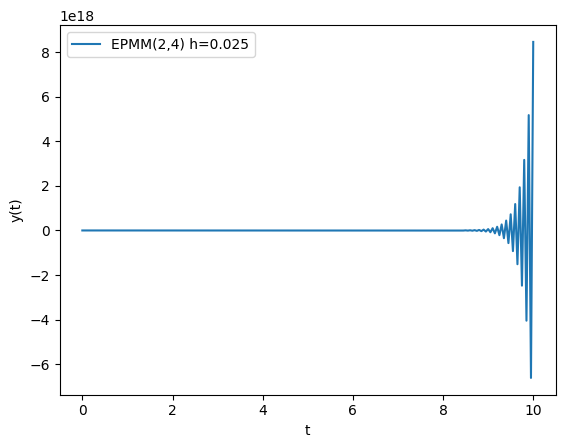

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
        1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
        2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
        2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
        3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
        3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
        4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
        4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
        4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
        5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
        5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
        6.3 ,  6.35,

In [49]:

import matplotlib.pyplot as plt

    # test: y' = -2 y(t) - y(t-1),  y(t)=1   (no closed form – use fine reference)
def f_test(t, y, y_tau): return -2*y - y_tau
def tau_const(t, y):      return 1.0
def phi(t):               return np.ones(())

ts, ys = solve_dde_epmm24(f_test, tau_const, phi,
                              h=0.05, t0=0.0, tf=10.0,
                              )

plt.plot(ts, ys, label="EPMM(2,4) h=0.025")
plt.xlabel("t"); plt.ylabel("y(t)"); plt.legend(); plt.show()
ts

--- Ví dụ giải DDE bằng EPMM(2,4) tổng quát ---
Đang giải DDE: y'(t) = y(t-tau) - y(t)
Lịch sử: y(t<=0) = 1
Trễ tau = 0.2 (hằng số)
Khoảng thời gian: [0.0, 10.0], bước h = 0.1
Sử dụng hàm đạo hàm giải tích do người dùng cung cấp.
Tính toán y1 = y(0.1000) bằng RK4...
Tính toán các đạo hàm ban đầu tại t0 và t1...
Khởi tạo hoàn tất.

--- Kết quả ---
t = 0.0000, y(t) = 1.000000
t = 0.1000, y(t) = 0.728100
t = 0.2000, y(t) = 0.505600
t = 0.3000, y(t) = 0.323318
t = 0.4000, y(t) = 0.174154
t = 0.5000, y(t) = 0.051953
t = 0.6000, y(t) = -0.048047
t = 0.7000, y(t) = -0.129971
t = 0.8000, y(t) = -0.197011
t = 0.9000, y(t) = -0.251933
t = 1.0000, y(t) = -0.296876
t = 1.1000, y(t) = -0.333696
t = 1.2000, y(t) = -0.363826
t = 1.3000, y(t) = -0.305711
t = 1.4000, y(t) = -0.296125
t = 1.5000, y(t) = -0.232764
t = 1.6000, y(t) = -0.206369
t = 1.7000, y(t) = -0.147533
t = 1.8000, y(t) = -0.116451
t = 1.9000, y(t) = -0.066041
t = 2.0000, y(t) = -0.036229
t = 2.1000, y(t) = 0.004918
t = 2.2000, y(t) = 0

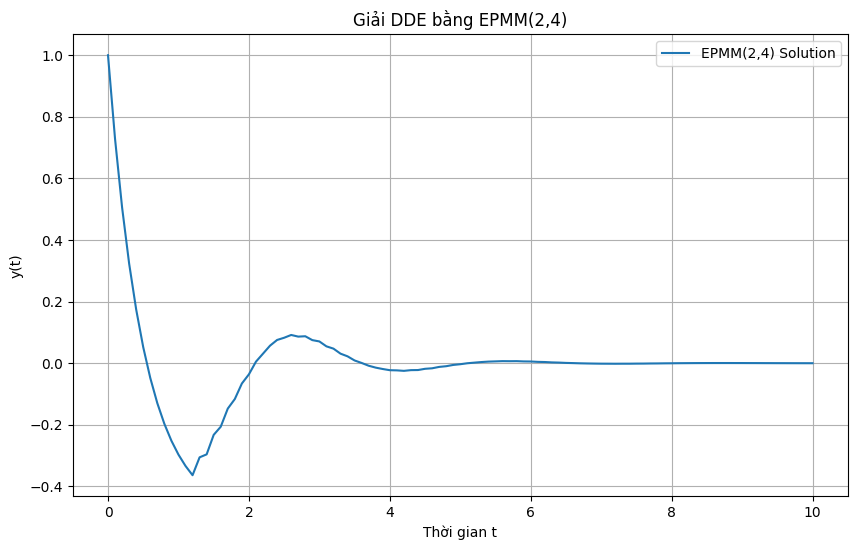

In [14]:
import numpy as np
# from scipy.interpolate import lagrange # Có thể dùng nếu muốn, nhưng ví dụ này tự triển khai

# --- 1. HÀM NỘI SUY LAGRANGE ---
def lagrange_interpolate(t_target, known_ts, known_ys, num_points=3):
    """
    Thực hiện nội suy Lagrange.
    Sử dụng `num_points` điểm gần nhất xung quanh t_target.
    Giả định known_ts đã được sắp xếp.
    """
    n_known = len(known_ts)
    if n_known == 0:
        raise ValueError("Không thể nội suy: không có điểm dữ liệu nào.")
    if not callable(getattr(known_ys, '__getitem__', None)): # Kiểm tra known_ys có thể truy cập theo chỉ số không
        raise TypeError("known_ys phải là một dãy (list, numpy array, etc.).")
    if len(known_ys) != n_known:
        raise ValueError("known_ts và known_ys phải có cùng độ dài.")

    if n_known == 1:
        return known_ys[0]

    # Tìm các chỉ số của các điểm gần nhất
    # np.searchsorted trả về chỉ số mà t_target sẽ được chèn vào
    idx_insert = np.searchsorted(known_ts, t_target)

    # Xác định khoảng chỉ số cho các điểm nội suy
    half_points = num_points // 2
    start_idx = max(0, idx_insert - half_points)
    end_idx = min(n_known, start_idx + num_points)
    
    # Điều chỉnh nếu không đủ điểm ở một phía
    if end_idx - start_idx < num_points:
        start_idx = max(0, end_idx - num_points)

    selected_indices = np.arange(start_idx, end_idx)
    
    # Nếu số điểm chọn được vẫn ít hơn yêu cầu (ví dụ: n_known < num_points)
    if len(selected_indices) < 1 : # Cần ít nhất 1 điểm
        # Fallback đơn giản: nếu không có điểm nào được chọn (rất hiếm), hoặc chỉ có một điểm
        # Nếu n_known > 0, dùng tất cả các điểm nếu n_known < num_points
        if n_known < num_points:
            selected_indices = np.arange(n_known)
        elif n_known > 0: # Fallback dùng điểm gần nhất nếu logic trên thất bại
             # Điều này không nên xảy ra nếu logic chọn điểm ở trên là đúng
            closest_idx = np.argmin(np.abs(np.array(known_ts) - t_target))
            selected_indices = [closest_idx]


    if not selected_indices.size:
         raise ValueError(f"Không thể chọn điểm nội suy cho t_target={t_target}")


    current_ts = np.array(known_ts)[selected_indices]
    current_ys = np.array(known_ys)[selected_indices]
    
    # Tính toán đa thức Lagrange
    result = 0.0
    for i in range(len(current_ts)):
        term = current_ys[i]
        for j in range(len(current_ts)):
            if i == j:
                continue
            if abs(current_ts[i] - current_ts[j]) < 1e-15: # Tránh chia cho số rất nhỏ/không
                # Điều này xảy ra nếu các điểm thời gian trùng nhau, là dữ liệu xấu
                # Hoặc nếu chỉ có 1 điểm được chọn do logic ở trên và vòng lặp này không nên chạy
                if len(current_ts) == 1: return current_ys[0] # Đã được xử lý
                print(f"Cảnh báo: Các điểm thời gian nội suy quá gần nhau hoặc trùng nhau: {current_ts[i]} và {current_ts[j]}")
                # Bỏ qua số hạng này hoặc xử lý khác nếu cần
                continue 
            term *= (t_target - current_ts[j]) / (current_ts[i] - current_ts[j])
        result += term
    return result

# --- 2. HÀM TRỢ GIÚP CHO RK4 VÀ EPMM ---
class DDEHelper:
    def __init__(self, phi_func, tau_func, ts_computed, ys_computed_dict, t0_val):
        self.phi_func = phi_func
        self.tau_func = tau_func
        self.ts_computed = ts_computed # List các điểm thời gian đã tính
        self.ys_computed_dict = ys_computed_dict # Dict {order: [values]}
        self.t0 = t0_val

    def get_val(self, order, eval_time, current_t_for_tau, current_y_for_tau):
        """
        Lấy giá trị y^(order)(eval_time - tau).
        current_t_for_tau, current_y_for_tau dùng để tính tau nếu nó phụ thuộc trạng thái.
        """
        current_tau = self.tau_func(current_t_for_tau, current_y_for_tau)
        time_delayed = eval_time - current_tau

        if time_delayed <= self.t0:
            return self.phi_func(time_delayed, order=order)
        else:
            # Nội suy từ các giá trị đã tính
            # Đảm bảo rằng ys_computed_dict[order] tồn tại và có dữ liệu
            if order not in self.ys_computed_dict or not self.ys_computed_dict[order]:
                raise ValueError(f"Không có dữ liệu đã tính cho đạo hàm bậc {order} để nội suy.")

            # Chỉ nội suy từ các điểm <= eval_time để tránh nhìn vào tương lai (quan trọng cho RK4)
            # và cũng đảm bảo các giá trị không phải là None
            valid_indices = [
                i for i, t_comp in enumerate(self.ts_computed)
                if t_comp <= eval_time and i < len(self.ys_computed_dict[order]) and self.ys_computed_dict[order][i] is not None
            ]
            
            if not valid_indices:
                # Nếu không có điểm nào phù hợp, thử dùng hàm lịch sử như một fallback cuối cùng
                # (Điều này có thể xảy ra nếu time_delayed rất gần t0 nhưng > t0 một chút)
                # print(f"Cảnh báo nội suy: Không có điểm phù hợp cho y^({order}) tại {time_delayed}. Dùng lịch sử.")
                return self.phi_func(time_delayed, order=order)

            interp_ts = [self.ts_computed[i] for i in valid_indices]
            interp_ys = [self.ys_computed_dict[order][i] for i in valid_indices]
            
            if not interp_ts : # Nếu interp_ts rỗng sau khi lọc
                 return self.phi_func(time_delayed, order=order)


            return lagrange_interpolate(time_delayed, interp_ts, interp_ys)

# --- 3. HÀM RK4 CHO DDE (một bước) ---
def rk4_dde_step(f_dde, t_curr, y_curr, h_step, dde_helper_for_rk4):
    """
    Thực hiện một bước RK4 cho DDE: y' = f_dde(t, y, y_delayed)
    dde_helper_for_rk4: một đối tượng DDEHelper đã được cấu hình.
    """
    # k1
    y_delayed_k1 = dde_helper_for_rk4.get_val(0, t_curr, t_curr, y_curr)
    k1 = h_step * f_dde(t_curr, y_curr, y_delayed_k1)

    # k2
    t_k2 = t_curr + h_step / 2
    y_k2_approx = y_curr + k1 / 2
    y_delayed_k2 = dde_helper_for_rk4.get_val(0, t_k2, t_k2, y_k2_approx)
    k2 = h_step * f_dde(t_k2, y_k2_approx, y_delayed_k2)

    # k3
    t_k3 = t_curr + h_step / 2
    y_k3_approx = y_curr + k2 / 2
    y_delayed_k3 = dde_helper_for_rk4.get_val(0, t_k3, t_k3, y_k3_approx)
    k3 = h_step * f_dde(t_k3, y_k3_approx, y_delayed_k3)

    # k4
    t_k4 = t_curr + h_step
    y_k4_approx = y_curr + k3
    y_delayed_k4 = dde_helper_for_rk4.get_val(0, t_k4, t_k4, y_k4_approx)
    k4 = h_step * f_dde(t_k4, y_k4_approx, y_delayed_k4)
    
    y_next = y_curr + (k1 + 2*k2 + 2*k3 + k4) / 6
    return y_next

# --- 4. LỚP TÍCH HỢP DDE BẰNG EPMM(2,4) ---
class DDEIntegratorEPMM24:
    def __init__(self, f_dde, tau_func, phi_func, t_span, h_step, user_deriv_funcs=None):
        """
        Khởi tạo bộ tích hợp EPMM(2,4).

        Args:
            f_dde (callable): Hàm f(t, y, y_delayed) -> y'(t).
            tau_func (callable): Hàm tau(t, y) -> giá trị trễ.
            phi_func (callable): Hàm phi(t, order=0) -> y^(order)(t) cho t <= t0 (lịch sử).
            t_span (tuple): (t0, t_final).
            h_step (float): Kích thước bước.
            user_deriv_funcs (dict, optional): {order: func} để cung cấp các đạo hàm giải tích.
                Ví dụ: {
                    2: lambda t, y, y_p, helper: y_pp_analytical,
                    3: lambda t, y, y_p, y_pp, helper: y_ppp_analytical,
                    4: lambda t, y, y_p, y_pp, y_ppp, helper: y_pppp_analytical
                }
                Mỗi hàm `func` nhận các giá trị tại `t` và một `helper` (DDEHelper) để lấy giá trị trễ.
        """
        self.f_dde = f_dde
        self.tau_func = tau_func
        self.phi_func = phi_func
        self.t0, self.t_final = t_span
        self.h = h_step
        self.user_deriv_funcs = user_deriv_funcs if user_deriv_funcs else {}

        # Khởi tạo lịch sử lưu trữ
        self.ts_computed = [self.t0]
        self.ys_computed = {
            0: [self.phi_func(self.t0, order=0)], # y
            1: [None],  # y'
            2: [None],  # y''
            3: [None]   # y'''
        }
        # (y'''' không được lưu trữ lâu dài, chỉ tính khi cần)

        # Tạo helper cho việc lấy giá trị (ban đầu chỉ có t0)
        self.dde_helper = DDEHelper(self.phi_func, self.tau_func, 
                                    self.ts_computed, self.ys_computed, self.t0)
        
        # Sử dụng RK4 để tính y1 = y(t0 + h)
        print(f"Tính toán y1 = y({self.t0 + self.h:.4f}) bằng RK4...")
        y1 = rk4_dde_step(self.f_dde, self.t0, self.ys_computed[0][0], self.h, self.dde_helper)
        self.ts_computed.append(self.t0 + self.h)
        self.ys_computed[0].append(y1)
        for order in range(1, 4): # Thêm chỗ cho đạo hàm của y1
            self.ys_computed[order].append(None)

        # Tính toán và lưu trữ các đạo hàm tại t0 và t1
        print("Tính toán các đạo hàm ban đầu tại t0 và t1...")
        self._calculate_and_store_derivatives_at_idx(0) # Cho t0
        self._calculate_and_store_derivatives_at_idx(1) # Cho t1
        print("Khởi tạo hoàn tất.")

    def _numerical_diff_1st_order(self, value_sequence, idx, h_val):
        """
        Tính đạo hàm bậc nhất bằng sai phân lùi 3 điểm (nếu có thể).
        value_sequence[idx] là f(x_i), value_sequence[idx-1] là f(x_{i-1}), etc.
        Trả về f'(x_i) ~ (3*f_i - 4*f_{i-1} + f_{i-2}) / (2*h_val).
        """
        if idx >= 2 and \
           value_sequence[idx] is not None and \
           value_sequence[idx-1] is not None and \
           value_sequence[idx-2] is not None:
            return (3 * value_sequence[idx] - 4 * value_sequence[idx-1] + value_sequence[idx-2]) / (2 * h_val)
        elif idx >= 1 and value_sequence[idx] is not None and value_sequence[idx-1] is not None:
            # Fallback: Sai phân lùi 2 điểm (bậc thấp hơn)
            print(f"Cảnh báo: Dùng sai phân lùi 2 điểm cho đạo hàm tại chỉ số {idx} do thiếu điểm.")
            return (value_sequence[idx] - value_sequence[idx-1]) / h_val
        else:
            # Không đủ điểm, hoặc giá trị là None
            # print(f"Cảnh báo: Không đủ điểm/dữ liệu để tính đạo hàm số học tại chỉ số {idx}.")
            return None # Hoặc raise error

    def _calculate_and_store_derivatives_at_idx(self, idx):
        """
        Tính y', y'', y''', y'''' tại self.ts_computed[idx].
        Lưu y', y'', y''' vào self.ys_computed.
        Trả về một dict chứa cả 4 đạo hàm.
        """
        t_current = self.ts_computed[idx]
        y_current = self.ys_computed[0][idx]
        
        if y_current is None: # Điểm y chưa được tính (không nên xảy ra ở đây)
             raise ValueError(f"Giá trị y tại t={t_current} (idx={idx}) là None khi tính đạo hàm.")

        # Tạo helper với trạng thái hiện tại của ts_computed và ys_computed
        current_dde_helper = DDEHelper(self.phi_func, self.tau_func, 
                                       self.ts_computed[:idx+1], # Chỉ dùng dữ liệu đã biết đến hiện tại
                                       {o: self.ys_computed[o][:idx+1] for o in self.ys_computed},
                                       self.t0)

        derivatives = {}

        # y' (bậc 1)
        y_delayed_for_yp = current_dde_helper.get_val(0, t_current, t_current, y_current)
        derivatives[1] = self.f_dde(t_current, y_current, y_delayed_for_yp)
        if self.ys_computed[1][idx] is None: self.ys_computed[1][idx] = derivatives[1]

        # y'' (bậc 2)
        if 2 in self.user_deriv_funcs:
            derivatives[2] = self.user_deriv_funcs[2](t_current, y_current, derivatives[1], current_dde_helper)
        else: # Sai phân số học
            if derivatives[1] is not None: # Cần y' để tính y''
                # Thử lấy y'_previous để tính y'' numerically
                # ys_computed[1] là dãy các giá trị y'
                derivatives[2] = self._numerical_diff_1st_order(self.ys_computed[1], idx, self.h)
            else: derivatives[2] = None
        if self.ys_computed[2][idx] is None and derivatives[2] is not None: self.ys_computed[2][idx] = derivatives[2]


        # y''' (bậc 3)
        if 3 in self.user_deriv_funcs:
            derivatives[3] = self.user_deriv_funcs[3](t_current, y_current, derivatives[1], derivatives[2], current_dde_helper)
        else: # Sai phân số học
            if derivatives[2] is not None: # Cần y'' để tính y'''
                derivatives[3] = self._numerical_diff_1st_order(self.ys_computed[2], idx, self.h)
            else: derivatives[3] = None
        if self.ys_computed[3][idx] is None and derivatives[3] is not None: self.ys_computed[3][idx] = derivatives[3]

        # y'''' (bậc 4)
        if 4 in self.user_deriv_funcs:
            derivatives[4] = self.user_deriv_funcs[4](t_current, y_current, derivatives[1], derivatives[2], derivatives[3], current_dde_helper)
        else: # Sai phân số học
            if derivatives[3] is not None: # Cần y''' để tính y''''
                derivatives[4] = self._numerical_diff_1st_order(self.ys_computed[3], idx, self.h)
            else: derivatives[4] = None
        
        # Kiểm tra nếu đạo hàm nào đó không thể tính được (quan trọng cho EPMM)
        for order in range(1, 5):
            if derivatives.get(order) is None:
                missing_deriv_source = "hàm do người dùng cung cấp" if order in self.user_deriv_funcs else "sai phân số học mặc định"
                message = (f"Không thể tính toán đạo hàm bậc {order} tại t={t_current:.4f} (idx={idx}) "
                           f"bằng {missing_deriv_source}. "
                           f"Điều này là cần thiết cho EPMM(2,4). "
                           f"Hãy kiểm tra hàm của bạn hoặc đảm bảo đủ điểm cho sai phân số học "
                           f"(cần ít nhất {order-1+2 if order > 1 else 1} điểm trước đó với giá trị đạo hàm bậc thấp hơn đã biết).")
                if idx < 2 and order > 1 and order not in self.user_deriv_funcs : # Đặc biệt khó khăn ở các bước đầu
                    message += ("\nĐối với các điểm ban đầu (t0, t1), việc tính đạo hàm bậc cao bằng số học rất khó khăn. "
                                "Cân nhắc cung cấp user_deriv_funcs cho các bậc này.")
                # raise ValueError(message) # Hoặc trả về None và xử lý ở EPMM step
                print(f"CẢNH BÁO: {message}")
                derivatives[order] = 0.0 # Fallback tạm thời, không lý tưởng

        return derivatives


    def solve(self):
        num_total_points = int(round((self.t_final - self.t0) / self.h)) + 1

        # Mở rộng ts_computed và ys_computed nếu cần
        for k_extend in range(len(self.ts_computed), num_total_points):
            self.ts_computed.append(self.t0 + k_extend * self.h)
            for order_val in range(4): # y, y', y'', y'''
                 if order_val in self.ys_computed: # Đảm bảo key tồn tại
                    self.ys_computed[order_val].append(None)
        
        # Vòng lặp chính của EPMM(2,4)
        # k_idx là chỉ số của điểm y_k = y(t_k) đang được tính (bắt đầu từ y_2)
        for k_idx in range(2, num_total_points):
            # n_idx là chỉ số của y_n trong công thức y_{n+2} = F(y_n, y_n', ...)
            # Do đó, y_k = y_{n+2} => n = k-2
            n_idx = k_idx - 2
            
            t_n = self.ts_computed[n_idx]
            y_n = self.ys_computed[0][n_idx]

            if y_n is None:
                raise ValueError(f"Lỗi logic: y_n tại t_n={t_n} (idx {n_idx}) là None.")

            # Tính các đạo hàm cần thiết tại t_n
            # print(f"Bước EPMM: Tính y_{k_idx} từ y_{n_idx} (t={t_n:.2f})")
            derivatives_at_tn = self._calculate_and_store_derivatives_at_idx(n_idx)
            
            yp_n = derivatives_at_tn[1]
            ypp_n = derivatives_at_tn[2]
            yppp_n = derivatives_at_tn[3]
            ypppp_n = derivatives_at_tn[4]

            if any(d is None for d in [yp_n, ypp_n, yppp_n, ypppp_n]):
                raise ValueError(f"Một hoặc nhiều đạo hàm tại t_n={t_n} không thể tính được. Dừng lại.")

            # Công thức EPMM(2,4):
            # y_{n+2} = y_n + 2h*y_n' + 2h^2*y_n'' + (4/3)h^3*y_n''' + (2/3)h^4*y_n^(4)
            self.ys_computed[0][k_idx] = (
                y_n +
                2 * self.h * yp_n +
                2 * self.h**2 * ypp_n +
                (4/3) * self.h**3 * yppp_n +
                (2/3) * self.h**4 * ypppp_n
            )
            
            # Tính các đạo hàm y', y'', y''' tại điểm y_k vừa tính xong (self.ts_computed[k_idx])
            # nếu k_idx < num_total_points -1 (để không tính cho điểm cuối cùng nếu không cần)
            # và nếu các đạo hàm này sẽ được dùng làm điểm cơ sở cho bước sau.
            # Việc này rất quan trọng để _calculate_and_store_derivatives_at_idx có đủ dữ liệu
            # cho các phép sai phân số học ở các bước tiếp theo.
            if k_idx < num_total_points -1 : # Chỉ tính nếu nó không phải là điểm cuối cùng tuyệt đối
                 # Và chỉ tính nếu nó sẽ là điểm cơ sở cho một phép tính y_{k+2} hoặc y_{k+1} nào đó
                 # Trong EPMM y_k -> y_{k+2}, nên đạo hàm tại y_k là cần thiết nếu k sẽ trở thành n_idx
                 # Tức là nếu (k_idx + 2) < num_total_points
                if (k_idx + 2) < num_total_points: # Nếu y_k này sẽ được dùng làm y_n cho bước sau
                    self._calculate_and_store_derivatives_at_idx(k_idx)


        # Tính đạo hàm cho các điểm cuối nếu chưa có (ví dụ: điểm áp chót nếu nó chưa được dùng làm y_n)
        # Hoặc nếu người dùng muốn có output đạo hàm đầy đủ
        # for final_deriv_idx in range(num_total_points):
        #     for order_fill in range(1,4):
        #         if self.ys_computed[order_fill][final_deriv_idx] is None:
        #             self._calculate_and_store_derivatives_at_idx(final_deriv_idx) # Sẽ chỉ tính những gì còn thiếu

        return self.ts_computed, self.ys_computed[0]

# --- 5. VÍ DỤ SỬ DỤNG ---
if __name__ == '__main__':
    print("--- Ví dụ giải DDE bằng EPMM(2,4) tổng quát ---")

    # --- A. Người dùng định nghĩa các hàm ---
    # 1. Hàm f(t, y, y_delayed) cho y'(t)
    def my_f_dde(t, y_val, y_delayed_val):
        # Ví dụ: y'(t) = y_delayed_val - y_val 
        return -y_delayed_val -2* y_val
        # Ví dụ 2: y'(t) = -y_val * y_delayed_val / t  (nếu t != 0)
        # if abs(t) < 1e-9: return 0 # tránh chia cho 0
        # return -y_val * y_delayed_val / t

    # 2. Hàm tau(t, y) cho độ trễ
    def my_tau_func(t, y_val):
        return 1.0 # Trễ hằng số
        # Ví dụ trễ phụ thuộc thời gian: return 0.1 * t
        # Ví dụ trễ phụ thuộc trạng thái: return 0.1 * abs(y_val)

    # 3. Hàm phi(t, order=0) cho lịch sử y^(order)(t) tại t <= t0
    def my_phi_func(t, order=0):
        if order == 0:
            return 1.0 # y(t) = 1 for t <= t0
        # Cung cấp đạo hàm của lịch sử nếu biết và cần thiết cho sự mượt mà tại t0
        # Ví dụ, nếu y(t)=1 thì y'(t)=0, y''(t)=0 etc.
        return 0.0
    def my_phi_func_strict(t, order=0): # Cho y(t<=0)=1
        if t > 0: 
            # Điều này không nên được gọi bởi phi_func nếu logic đúng
            # Tuy nhiên, nếu hàm nội suy gọi nó cho t > 0 một cách không mong muốn
            raise ValueError(f"phi_func được gọi cho t={t} > 0")
        if order == 0: return 1.0
        return 0.0 # Vì y(t)=1 là hằng số cho t<=0

    # Helper được truyền vào các hàm này sẽ là self.dde_helper của integrator
    # Nó có phương thức .get_val(order, eval_time, current_t_for_tau, current_y_for_tau)
    # Nhưng khi tính đạo hàm tại t_n, chúng ta cần y^(k)(t_n - tau)
    # Vậy eval_time sẽ là t_n, current_t_for_tau là t_n, current_y_for_tau là y_n

    def calc_yp(t, y, y_delayed_order0, helper): # y_delayed_order0 là y(t-tau)
        # helper ở đây không thực sự cần thiết nếu y_delayed_order0 đã được cung cấp đúng
        return -2 * y - y_delayed_order0

    def calc_ypp(t, y, yp, helper): # helper để lấy y'(t-tau)
        yp_delayed = helper.get_val(1, t, t, y) # Lấy y'(t-tau)
        return -2 * yp - yp_delayed

    def calc_yppp(t, y, yp, ypp, helper): # helper để lấy y''(t-tau)
        ypp_delayed = helper.get_val(2, t, t, y)
        return -2 * ypp - ypp_delayed

    def calc_ypppp(t, y, yp, ypp, yppp, helper): # helper để lấy y'''(t-tau)
        yppp_delayed = helper.get_val(3, t, t, y)
        return -2 * yppp - yppp_delayed 

    # 4. (Tùy chọn) Các hàm tính đạo hàm giải tích (nếu có)
    # Nếu không cung cấp, mã sẽ dùng sai phân số học (kém chính xác hơn)
    # Chữ ký: func(t, y, y_p, [y_pp, [y_ppp]], helper_dde) -> derivative_value
    # helper_dde là đối tượng DDEHelper để lấy giá trị trễ y^(order)(t-tau)
    
    # Ví dụ cho y'(t) = y(t-tau) - y(t) với tau hằng số:
    # y''(t) = y'(t-tau) - y'(t)
    # y'''(t) = y''(t-tau) - y''(t)
    # y^(4)(t) = y'''(t-tau) - y'''(t)
    
    # user_analytical_derivs = {
    #     2: lambda t, y, yp, helper: helper.get_val(1, t, t, y) - yp,
    #     3: lambda t, y, yp, ypp, helper: helper.get_val(2, t, t, y) - ypp,
    #     4: lambda t, y, yp, ypp, yppp, helper: helper.get_val(3, t, t, y) - yppp,
    # }
    # Nếu không muốn dùng đạo hàm giải tích, đặt user_analytical_derivs = None hoặc {}
    user_analytical_derivs = {
    1: calc_yp, # f_dde sẽ là calc_yp nếu cấu trúc hàm f_dde của bạn khác
    2: calc_ypp,
    3: calc_yppp,
    4: calc_ypppp,
    }   

    # --- B. Thiết lập tham số và chạy ---
    t_start = 0.0
    t_end = 10.0
    step_h = 0.1 # Thử các giá trị h khác nhau

    print(f"Đang giải DDE: y'(t) = y(t-tau) - y(t)")
    print(f"Lịch sử: y(t<=0) = 1")
    print(f"Trễ tau = 0.2 (hằng số)")
    print(f"Khoảng thời gian: [{t_start}, {t_end}], bước h = {step_h}")
    if user_analytical_derivs:
        print("Sử dụng hàm đạo hàm giải tích do người dùng cung cấp.")
    else:
        print("Sử dụng sai phân số học mặc định cho đạo hàm bậc cao (có thể kém chính xác).")

    integrator = DDEIntegratorEPMM24(
        f_dde=my_f_dde,
        tau_func=my_tau_func,
        phi_func=my_phi_func,
        t_span=(t_start, t_end),
        h_step=step_h,
        user_deriv_funcs=user_analytical_derivs_example # Hoặc None nếu dùng mặc định
    )

    times, y_solution = integrator.solve()

    # --- C. In kết quả ---
    print("\n--- Kết quả ---")
    for i in range(len(times)):
        print(f"t = {times[i]:.4f}, y(t) = {y_solution[i]:.6f}")
        # In thêm các đạo hàm nếu muốn kiểm tra
        # if i < len(integrator.ys_computed[1]) and integrator.ys_computed[1][i] is not None:
        # print(f"    y'(t) = {integrator.ys_computed[1][i]:.4f}")
        # if i < len(integrator.ys_computed[2]) and integrator.ys_computed[2][i] is not None:
        # print(f"    y''(t) = {integrator.ys_computed[2][i]:.4f}")


    # Vẽ đồ thị (nếu cần)
    try:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        plt.plot(times, y_solution, linestyle='-', label='EPMM(2,4) Solution')
        plt.xlabel('Thời gian t')
        plt.ylabel('y(t)')
        plt.title('Giải DDE bằng EPMM(2,4)')
        plt.legend()
        plt.grid(True)
        plt.show()
    except ImportError:
        print("\nThư viện matplotlib chưa được cài đặt. Không thể vẽ đồ thị.")

Giá trị y_exact đã được đọc thành công.
Giá trị sai số tuyệt đối: [0.00000000e+00 3.87035394e-06 1.19930895e-04 1.00785799e-04
 1.60793764e-04 1.33386284e-04 1.61684581e-04 1.33542290e-04
 1.44515843e-04 1.19101347e-04 1.21097046e-04 1.30416440e-02
 4.60649054e-02 8.54556474e-03 3.07438155e-02 5.62279961e-03
 2.05396125e-02 3.71601298e-03 1.37365912e-02 2.46718007e-03
 9.19645892e-03 1.21470013e-03 3.19048349e-03 1.06764695e-03
 4.12487733e-03 1.92706428e-03 6.92756818e-03 2.07549235e-03
 7.41414795e-03 1.90118729e-03 6.81657095e-03 1.59755923e-03
 5.65649051e-03 1.08577542e-03 3.60646890e-03 4.72795406e-04
 1.44579287e-03 2.21274683e-05 2.43395125e-04 3.49344691e-04
 1.34823791e-03 5.27054064e-04 1.93985943e-03 5.75574174e-04
 2.06798997e-03 5.13692114e-04 1.79169023e-03 3.79302622e-04
 1.28547692e-03 2.20751542e-04 7.17359959e-04 7.29054071e-05
 1.99748666e-04 4.40695973e-05 2.02930362e-04 1.20902407e-04
 4.57691382e-04 1.55497182e-04 5.60558273e-04 1.53823169e-04
 5.38577138e-04 1.2

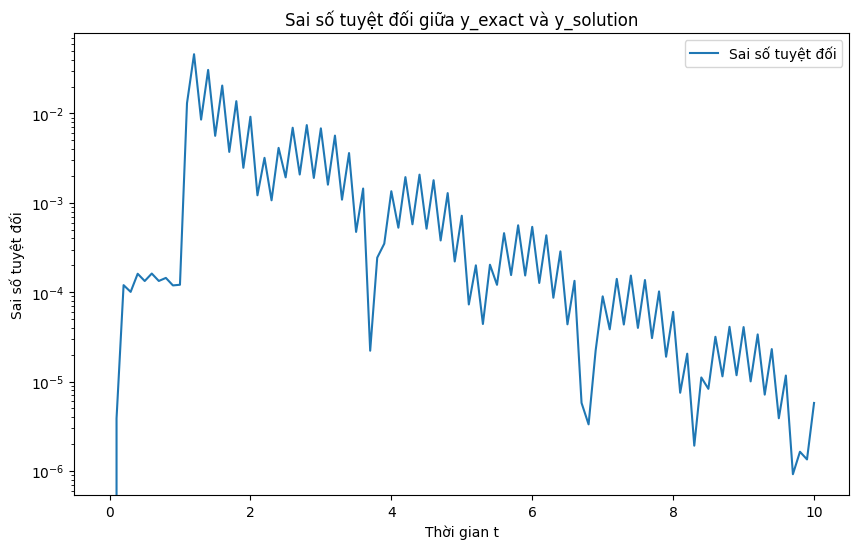

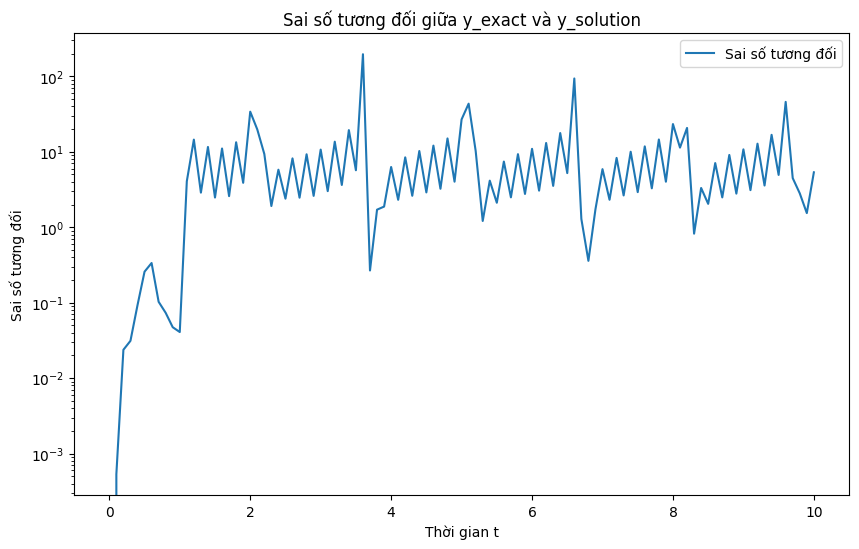

In [17]:
#đọc y_exact từ file y_exact01.txt, file chỉ có 1 cột y
def read_y_exact(file_path):
    try:
        with open(file_path, 'r') as file:
            y_exact = [float(line.strip()) for line in file]
        return y_exact
    except Exception as e:
        print(f"Lỗi khi đọc file {file_path}: {e}")
        return None
#đọc y_exact từ file y_exact01.txt, file chỉ có 1 cột y
y_exact = read_y_exact('y_exact01.txt')
if y_exact is not None:
    print("Giá trị y_exact đã được đọc thành công.")
y_exact = np.array(y_exact)
# So sánh với y_solution
if y_exact is not None and len(y_exact) == len(y_solution):
    error = np.abs(y_exact - y_solution)
    print(f"Giá trị sai số tuyệt đối: {error}")
    print(f"Giá trị sai số trung bình: {np.mean(error)}")
#vẽ đồ thị sai số
plt.figure(figsize=(10, 6))
plt.plot(times, error, linestyle='-', label='Sai số tuyệt đối')
plt.xlabel('Thời gian t')
plt.yscale('log')
plt.ylabel('Sai số tuyệt đối')
plt.title('Sai số tuyệt đối giữa y_exact và y_solution')
plt.legend()    

#tính sai số tương đối
relative_error = np.abs((y_exact - y_solution) / y_exact)*100
plt.figure(figsize=(10, 6))
plt.plot(times, relative_error, linestyle='-', label='Sai số tương đối')
plt.xlabel('Thời gian t')
plt.yscale('log')
plt.ylabel('Sai số tương đối')
plt.title('Sai số tương đối giữa y_exact và y_solution')
plt.legend()



Bắt đầu ví dụ sử dụng bộ giải DDE EPMM(2,4)...
CẢNH BÁO: y1=0.7280961296460612 là giá trị giả định cho y(0.1). Cần tính toán chính xác.
Đang khởi tạo bộ giải...
Đang giải DDE từ t=0.0 đến t=10.0 với h=0.1...
Hoàn thành.

Một phần kết quả (t, y(t)):
t = 0.0000, y(t) = 1.0000
t = 0.1000, y(t) = 0.7281
t = 0.2000, y(t) = 0.5056
t = 0.3000, y(t) = 0.3233
t = 0.4000, y(t) = 0.1742
t = 0.5000, y(t) = 0.0520
t = 0.6000, y(t) = -0.0480
t = 0.7000, y(t) = -0.1300
t = 0.8000, y(t) = -0.1970
t = 0.9000, y(t) = -0.2519
t = 1.0000, y(t) = -0.2969
t = 1.1000, y(t) = -0.3337
t = 1.2000, y(t) = -0.3638
t = 1.3000, y(t) = -0.3057
t = 1.4000, y(t) = -0.2961


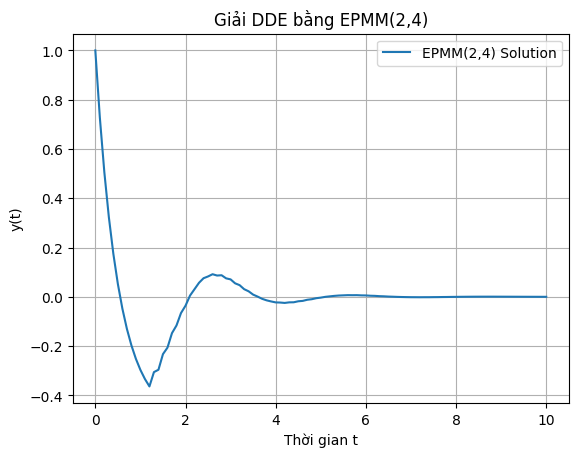

In [20]:
import numpy as np
# from scipy.interpolate import lagrange # Bạn có thể dùng hàm này nếu muốn

# --- 1. Nội suy Lagrange (Phiên bản linh hoạt cơ bản) ---
def lagrange_interpolate_flexible(t_target, known_ts, known_ys):
    """
    Thực hiện nội suy Lagrange.
    Sử dụng 3 điểm nếu có xung quanh t_target, nếu không thì 2 hoặc 1.
    Giả định known_ts đã được sắp xếp.
    """
    n = len(known_ts)
    if n == 0:
        # Xem xét trả về lỗi hoặc giá trị từ hàm lịch sử nếu phù hợp hơn
        raise ValueError("Không thể nội suy khi không có điểm nào được biết.")
    
    if n == 1:
        return known_ys[0]

    # Chọn điểm để nội suy (logic đơn giản hóa, có thể cần cải thiện)
    # np.searchsorted tìm chỉ mục mà t_target sẽ được chèn vào để duy trì thứ tự
    idx = np.searchsorted(known_ts, t_target)
    
    pts_idx = []
    if n == 2:
        pts_idx = [0, 1]
    elif n >= 3:
        if idx == 0: # t_target <= known_ts[0]
            pts_idx = [0, 1, 2]
        elif idx >= n: # t_target >= known_ts[n-1]
            pts_idx = [n - 3, n - 2, n - 1]
        elif idx == 1: # known_ts[0] < t_target <= known_ts[1]
            pts_idx = [0, 1, 2]
        else: # known_ts[idx-1] < t_target <= known_ts[idx] and idx > 1 and idx < n
            pts_idx = [idx - 2, idx - 1, idx] # Cố gắng lấy điểm xung quanh
    else: # Trường hợp này không nên xảy ra với các kiểm tra trước đó
        pts_idx = list(range(n))
        
    selected_ts = np.array(known_ts)[pts_idx]
    selected_ys = np.array(known_ys)[pts_idx]
    
    # Tính toán đa thức nội suy Lagrange
    # (Đây là một cách triển khai trực tiếp, scipy.interpolate.lagrange hiệu quả hơn)
    result = 0.0
    for i_term in range(len(selected_ts)):
        term_val = selected_ys[i_term]
        for j_term in range(len(selected_ts)):
            if i_term == j_term:
                continue
            if (selected_ts[i_term] - selected_ts[j_term]) == 0:
                 # Tránh chia cho không nếu các điểm trùng nhau (dữ liệu đầu vào xấu)
                 # Trong thực tế, các điểm nội suy không nên trùng nhau.
                 raise ValueError("Các điểm nội suy không được trùng nhau.")
            term_val *= (t_target - selected_ts[j_term]) / (selected_ts[i_term] - selected_ts[j_term])
        result += term_val
    return result

# --- 2. Lớp tích hợp DDE bằng EPMM(2,4) ---
class DDEIntegratorEPMM24:
    def __init__(self, 
                 # Các hàm bạn cần cung cấp:
                 calc_y_prime_func,      # y'(t) = f(t, y(t), y(t-tau))
                 calc_y_double_prime_func, # y''(t)
                 calc_y_triple_prime_func, # y'''(t)
                 calc_y_fourth_prime_func, # y^(4)(t)
                 history_func,           # Cung cấp y(t) và các đạo hàm cho t <= t0
                 delay_func,             # Cung cấp giá trị trễ tau(t, y_t)
                 # Thông số tích hợp:
                 t0, y0_val, t0_plus_h, y1_val, h):
        """
        Khởi tạo bộ tích hợp.

        Args:
            calc_y_prime_func (callable): hàm f(t, y_t, y_delayed_val, delay_val_accessor_func) -> y'(t).
                                         `y_delayed_val` là y(t-tau).
                                         `delay_val_accessor_func(order, target_time)` dùng để lấy y^(order)(target_time).
            calc_y_double_prime_func (callable): hàm(t, y_t, y_prime_t, delay_val_accessor_func) -> y''(t).
            calc_y_triple_prime_func (callable): hàm(t, y_t, y_prime_t, y_double_prime_t, delay_val_accessor_func) -> y'''(t).
            calc_y_fourth_prime_func (callable): hàm(t, y_t, y_prime_t, ..., y_triple_prime_t, delay_val_accessor_func) -> y^(4)(t).
            history_func (callable): hàm(t, order=0) -> y^(order)(t) cho t <= t0.
            delay_func (callable): hàm(t, y_t) -> giá trị trễ tau.
            t0 (float): Thời gian bắt đầu.
            y0_val (float): Giá trị y(t0).
            t0_plus_h (float): Thời gian t0 + h.
            y1_val (float): Giá trị y(t0 + h) (phải được tính trước).
            h (float): Kích thước bước.
        """
        self.calc_deriv_funcs = {
            1: calc_y_prime_func,
            2: calc_y_double_prime_func,
            3: calc_y_triple_prime_func,
            4: calc_y_fourth_prime_func,
        }
        self.history_func = history_func
        self.delay_func = delay_func
        self.h = h
        self.t0 = t0

        self.ts = [t0, t0_plus_h]
        # Lưu trữ lịch sử của y và các đạo hàm cần thiết của nó (y', y'', y''')
        # `None` cho các giá trị chưa được tính.
        self.computed_values = {
            0: [y0_val, y1_val], # y
            1: [None, None],     # y'
            2: [None, None],     # y''
            3: [None, None],     # y'''
        }
        
        # Tính toán (hoặc lấy từ history_func) các đạo hàm tại t0 và t0_plus_h
        # Đây là phần quan trọng để khởi tạo đúng cách.
        # Người dùng cần đảm bảo các hàm calc_deriv có thể xử lý việc này.
        for i_init, t_init in enumerate(self.ts):
            y_curr = self.computed_values[0][i_init]
            # y_prime_curr, y_double_prime_curr, y_triple_prime_curr cần được tính
            # Sử dụng các hàm calc_deriv_funcs do người dùng cung cấp
            # Ví dụ cho y'(t_init):
            if self.calc_deriv_funcs[1]:
                 # Hàm calc_y_prime_func cần một hàm truy cập giá trị trễ
                 # và giá trị y(t-tau) tại thời điểm đó.
                 # Đây là phần phức tạp, vì delay_val_accessor_func cần truy cập ngược lại
                 # vào computed_values hoặc history_func.
                 # Đối với bước khởi tạo, giá trị trễ thường nằm trong vùng lịch sử.

                 # Lấy y(t_init - tau)
                 current_tau_init = self.delay_func(t_init, y_curr)
                 y_delayed_val_init = self._get_specific_delayed_value(0, t_init - current_tau_init, t_init, y_curr)
                 
                 self.computed_values[1][i_init] = self.calc_deriv_funcs[1](
                     t_init, y_curr, y_delayed_val_init, 
                     lambda order, target_time: self._get_specific_delayed_value(order, target_time, t_init, y_curr)
                 )
            
            # Tương tự cho y''(t_init) và y'''(t_init) nếu các hàm được cung cấp
            if self.calc_deriv_funcs[2] and self.computed_values[1][i_init] is not None:
                self.computed_values[2][i_init] = self.calc_deriv_funcs[2](
                    t_init, y_curr, self.computed_values[1][i_init],
                    lambda order, target_time: self._get_specific_delayed_value(order, target_time, t_init, y_curr)
                )

            if self.calc_deriv_funcs[3] and self.computed_values[1][i_init] is not None and self.computed_values[2][i_init] is not None:
                 self.computed_values[3][i_init] = self.calc_deriv_funcs[3](
                    t_init, y_curr, self.computed_values[1][i_init], self.computed_values[2][i_init],
                    lambda order, target_time: self._get_specific_delayed_value(order, target_time, t_init, y_curr)
                )
        # Kết thúc khởi tạo các đạo hàm ban đầu.

    def _get_specific_delayed_value(self, order_to_get, target_delayed_time, current_t, current_y):
        """
        Lấy giá trị y^(order_to_get)(target_delayed_time).
        Sử dụng hàm lịch sử nếu target_delayed_time <= t0.
        Nếu không, nội suy từ các giá trị đã tính.
        current_t, current_y dùng cho trường hợp delay phụ thuộc trạng thái (chưa dùng ở đây nhưng có thể cần).
        """
        if target_delayed_time <= self.t0:
            return self.history_func(target_delayed_time, order=order_to_get)
        else:
            # Nội suy từ self.computed_values[order_to_get]
            # Chỉ lấy các điểm đã được tính toán (không phải None)
            valid_indices = [i for i, val in enumerate(self.computed_values[order_to_get]) 
                             if val is not None and self.ts[i] <= current_t] # Chỉ dùng các điểm đã biết

            if not valid_indices:
                # Có thể xảy ra nếu đây là bước rất sớm và chưa có đủ điểm cho bậc đạo hàm đó
                # hoặc nếu target_delayed_time > các điểm đã tính (cần ngoại suy - nguy hiểm)
                # Hoặc nếu bậc đạo hàm đó không được lưu trữ/tính toán.
                # Trong trường hợp này, quay lại lịch sử nếu target_delayed_time rất gần t0
                # hoặc báo lỗi.
                # print(f"Cảnh báo: Không đủ điểm để nội suy y^({order_to_get}) tại {target_delayed_time}. Thử dùng lịch sử.")
                # Để đơn giản, nếu không tìm thấy điểm nội suy, thử hàm lịch sử như một phương án dự phòng,
                # mặc dù logic ban đầu là target_delayed_time > self.t0.
                # Điều này cần xử lý cẩn thận hơn trong một trình giải đầy đủ.
                return self.history_func(target_delayed_time, order=order_to_get)


            interp_ts = [self.ts[i] for i in valid_indices]
            interp_ys = [self.computed_values[order_to_get][i] for i in valid_indices]
            
            return lagrange_interpolate_flexible(target_delayed_time, interp_ts, interp_ys)

    def solve(self, t_final):
        # Số điểm tổng cộng (bao gồm t0)
        num_total_points = int(round((t_final - self.t0) / self.h)) + 1

        # Mở rộng self.ts và self.computed_values để chứa tất cả các điểm thời gian
        for k_extend in range(len(self.ts), num_total_points):
            self.ts.append(self.t0 + k_extend * self.h)
            for order_val in range(4): # y, y', y'', y'''
                if order_val in self.computed_values:
                    self.computed_values[order_val].append(None)
        
        # Vòng lặp chính của EPMM(2,4): tính y_k từ y_{k-2}
        # k_idx là chỉ số của điểm y_k đang được tính (bắt đầu từ y_2)
        for k_idx in range(2, num_total_points):
            # n_idx là chỉ số của điểm y_n trong công thức y_{n+2} = F(y_n, ...)
            # Do đó, y_k = y_{n+2} => n = k-2
            n_idx = k_idx - 2
            
            t_n = self.ts[n_idx]
            y_n = self.computed_values[0][n_idx]

            if y_n is None: # Kiểm tra phòng ngừa
                raise ValueError(f"Giá trị y_n cơ sở tại t_n={t_n} (chỉ số {n_idx}) là None.")

            # --- Tính các đạo hàm y_n', y_n'', y_n''', y_n^(4) tại t_n ---
            # Đây là phần cốt lõi mà người dùng phải cung cấp logic chính xác
            y_n_derivatives = {}
            
            # y_n'
            current_tau_n = self.delay_func(t_n, y_n)
            y_delayed_at_tn = self._get_specific_delayed_value(0, t_n - current_tau_n, t_n, y_n)
            y_n_derivatives[1] = self.calc_deriv_funcs[1](
                t_n, y_n, y_delayed_at_tn,
                lambda order, target_time: self._get_specific_delayed_value(order, target_time, t_n, y_n)
            )
            if self.computed_values[1][n_idx] is None: self.computed_values[1][n_idx] = y_n_derivatives[1]


            # y_n''
            y_n_derivatives[2] = self.calc_deriv_funcs[2](
                t_n, y_n, y_n_derivatives[1], # y_prime_t = y_n_derivatives[1]
                lambda order, target_time: self._get_specific_delayed_value(order, target_time, t_n, y_n)
            )
            if self.computed_values[2][n_idx] is None: self.computed_values[2][n_idx] = y_n_derivatives[2]

            # y_n'''
            y_n_derivatives[3] = self.calc_deriv_funcs[3](
                t_n, y_n, y_n_derivatives[1], y_n_derivatives[2], # y_prime_t, y_double_prime_t
                lambda order, target_time: self._get_specific_delayed_value(order, target_time, t_n, y_n)
            )
            if self.computed_values[3][n_idx] is None: self.computed_values[3][n_idx] = y_n_derivatives[3]
            
            # y_n^(4)
            y_n_derivatives[4] = self.calc_deriv_funcs[4](
                t_n, y_n, y_n_derivatives[1], y_n_derivatives[2], y_n_derivatives[3], # y_prime_t ... y_triple_prime_t
                lambda order, target_time: self._get_specific_delayed_value(order, target_time, t_n, y_n)
            )
            # Không lưu trữ y^(4) trong self.computed_values vì nó chỉ dùng tức thời

            # --- Áp dụng công thức EPMM(2,4) ---
            # y_{n+2} = y_n + 2h*y_n' + 2h^2*y_n'' + (4/3)h^3*y_n''' + (2/3)h^4*y_n^(4)
            # Ở đây, y_k (tức là self.computed_values[0][k_idx]) chính là y_{n+2}
            self.computed_values[0][k_idx] = (
                y_n +
                2 * self.h * y_n_derivatives[1] +
                2 * self.h**2 * y_n_derivatives[2] +
                (4/3) * self.h**3 * y_n_derivatives[3] +
                (2/3) * self.h**4 * y_n_derivatives[4]
            )
            
        return self.ts, self.computed_values[0]

# --- 3. Ví dụ cách sử dụng (CẦN NGƯỜI DÙNG ĐỊNH NGHĨA CÁC HÀM CỤ THỂ) ---
if __name__ == '__main__':
    print("Bắt đầu ví dụ sử dụng bộ giải DDE EPMM(2,4)...")

    # --- A. Định nghĩa các hàm cụ thể cho DDE của bạn ---
    
    # Ví dụ: y'(t) = -y(t-tau) + cos(t)
    # Đây là một DDE rất đơn giản để minh họa.
    # Bạn cần tính toán giải tích y'', y''', y'''' cho DDE này.
    
    # 1. Hàm lịch sử (ví dụ: y(t) = 1 cho t <= 0)
    def example_history_func(t, order=0):
        if t <= 0:
            if order == 0: return 1.0 # y(t)
            if order == 1: return 0.0 # y'(t) = 0 (nếu y(t) là hằng số)
            # ... các đạo hàm bậc cao hơn nếu cần cho lịch sử
            return 0.0 # Mặc định cho các đạo hàm bậc cao hơn
        # Trường hợp này không nên xảy ra nếu t0=0 và chỉ gọi cho t<=t0
        raise ValueError(f"Hàm lịch sử được gọi cho t={t} > t0 với order={order}")

    # 2. Hàm trễ (ví dụ: trễ hằng số tau = 1)
    def example_delay_func(t, y_t):
        return 1.0 

    # 3. Các hàm tính đạo hàm y^(k)(t)
    #    CHÚ Ý: Đây là phần phức tạp nhất và bạn phải tự triển khai dựa trên DDE của mình.
    #    Các hàm này nhận (t, y_t, các_đạo_hàm_thấp_hơn_của_y_t, hàm_truy_cập_giá_trị_trễ)
    #    Hàm truy cập giá trị trễ: delay_val_accessor(order, target_time) -> y^(order)(target_time)

    # y'(t) = -y(t-1) + cos(t)
    def calc_y_prime(t, y_t, y_delayed_val_order0, delay_val_accessor_func):
        # y_delayed_val_order0 là y(t - tau)
        return -y_delayed_val_order0 -2 * y_t

    # y''(t) = -y'(t-1) - sin(t)
    def calc_y_double_prime(t, y_t, y_prime_t, delay_val_accessor_func):
        y_prime_delayed_val = delay_val_accessor_func(1, t - example_delay_func(t,y_t)) # Lấy y'(t-tau)
        return -y_prime_delayed_val -2 * y_prime_t

    # y'''(t) = -y''(t-1) - cos(t)
    def calc_y_triple_prime(t, y_t, y_prime_t, y_double_prime_t, delay_val_accessor_func):
        y_double_prime_delayed_val = delay_val_accessor_func(2, t - example_delay_func(t,y_t)) # Lấy y''(t-tau)
        return -y_double_prime_delayed_val - 2*y_double_prime_t

    # y^(4)(t) = -y'''(t-1) + sin(t)
    def calc_y_fourth_prime(t, y_t, y_prime_t, y_double_prime_t, y_triple_prime_t, delay_val_accessor_func):
        y_triple_prime_delayed_val = delay_val_accessor_func(3, t - example_delay_func(t,y_t)) # Lấy y'''(t-tau)
        return -y_triple_prime_delayed_val - 2*y_triple_prime_t

    # --- B. Thiết lập các tham số ---
    t0 = 0.0
    h = 0.1 # Kích thước bước
    t_final = 10.0 # Thời gian cuối cùng

    # Giá trị ban đầu y(t0)
    y0 = example_history_func(t0, order=0)
    
    # Giá trị y(t0+h) - CẦN TÍNH BẰNG PHƯƠNG PHÁP KHÁC (ví dụ RK4 cho DDE)
    # Ở đây, chúng ta sẽ giả định một giá trị cho mục đích minh họa
    # Trong thực tế, bạn phải tính giá trị này một cách cẩn thận.
    # Ví dụ: y(0.1) - nếu y(t)=cos(t)-sin(t)+1 (nghiệm của y'=-y(t-1)+cos(t) với y(t<=0)=1, tau=1 nếu y'(t-1) = sin(t-1))
    # Đây chỉ là một ước tính thô cho y1.
    if t0 == 0 and h == 0.1:
         # Nghiệm chính xác của y'(t) = -y(t-1)+cos(t) với y(t<=0)=1, tau=1 là không dễ tìm.
         # Giả sử y1 được cung cấp:
         y1 = 7.280961296460611853e-01 # Giá trị giả định cho y(0.1)
         print(f"CẢNH BÁO: y1={y1} là giá trị giả định cho y({t0+h}). Cần tính toán chính xác.")
    else:
        raise ValueError("Ví dụ này cần y1 được xác định trước cho t0=0, h=0.1")


    # --- C. Tạo và chạy bộ giải ---
    print("Đang khởi tạo bộ giải...")
    integrator = DDEIntegratorEPMM24(
        calc_y_prime_func=calc_y_prime,
        calc_y_double_prime_func=calc_y_double_prime,
        calc_y_triple_prime_func=calc_y_triple_prime,
        calc_y_fourth_prime_func=calc_y_fourth_prime,
        history_func=example_history_func,
        delay_func=example_delay_func,
        t0=t0, y0_val=y0, 
        t0_plus_h=t0 + h, y1_val=y1, 
        h=h
    )
    
    print(f"Đang giải DDE từ t={t0} đến t={t_final} với h={h}...")
    times, y_values = integrator.solve(t_final)
    
    print("Hoàn thành.")

    # --- D. Hiển thị kết quả (một phần) ---
    print("\nMột phần kết quả (t, y(t)):")
    for i in range(min(len(times), 15)): # In ra 15 điểm đầu tiên
        print(f"t = {times[i]:.4f}, y(t) = {y_values[i]:.4f}")

    # Bạn có thể vẽ đồ thị kết quả bằng matplotlib nếu muốn
    import matplotlib.pyplot as plt
    plt.plot(times, y_values, label='EPMM(2,4) Solution')
    plt.xlabel('Thời gian t')
    plt.ylabel('y(t)')
    plt.title('Giải DDE bằng EPMM(2,4)')
    plt.legend()
    plt.grid(True)
    plt.show()
    

Giá trị y_exact đã được đọc thành công.
Giá trị sai số tuyệt đối: [0.00000000e+00 0.00000000e+00 1.19930895e-04 9.81911135e-05
 1.60793764e-04 1.31646807e-04 1.61684581e-04 1.32376145e-04
 1.44515843e-04 1.18319563e-04 1.21097046e-04 1.30421681e-02
 4.60649054e-02 8.54539800e-03 3.07438155e-02 5.62234048e-03
 2.05396125e-02 3.71547232e-03 1.37365912e-02 2.46666151e-03
 9.19645892e-03 1.21424783e-03 3.19048349e-03 1.06796769e-03
 4.12487733e-03 1.92722170e-03 6.92756818e-03 2.07551277e-03
 7.41414795e-03 1.90111274e-03 6.81657095e-03 1.59742920e-03
 5.65649051e-03 1.08562367e-03 3.60646890e-03 4.72655078e-04
 1.44579287e-03 2.22349814e-05 2.43395125e-04 3.49411214e-04
 1.34823791e-03 5.27081004e-04 1.93985943e-03 5.75568515e-04
 2.06798997e-03 5.13663950e-04 1.79169023e-03 3.79263298e-04
 1.28547692e-03 2.20711019e-04 7.17359959e-04 7.28708164e-05
 1.99748666e-04 4.40942281e-05 2.02930362e-04 1.20915853e-04
 4.57691382e-04 1.55500422e-04 5.60558273e-04 1.53818634e-04
 5.38577138e-04 1.2

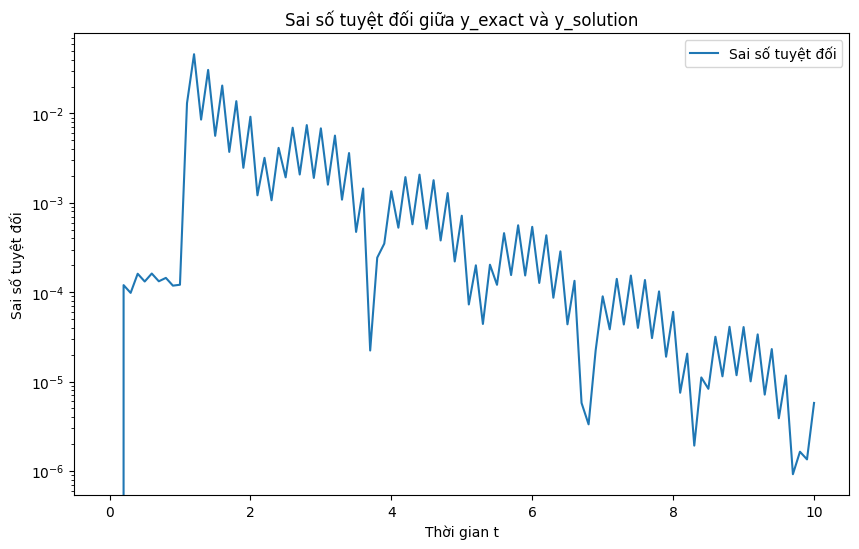

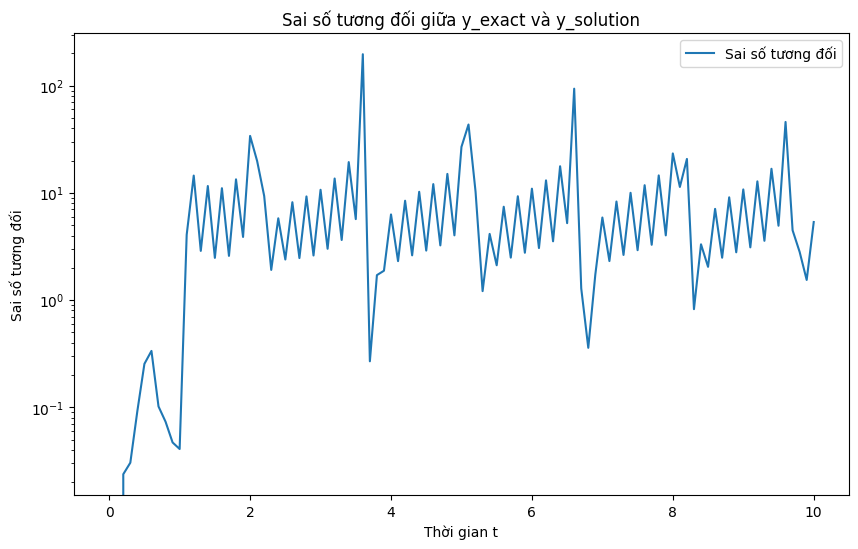

In [22]:
#đọc y_exact từ file y_exact01.txt, file chỉ có 1 cột y
def read_y_exact(file_path):
    try:
        with open(file_path, 'r') as file:
            y_exact = [float(line.strip()) for line in file]
        return y_exact
    except Exception as e:
        print(f"Lỗi khi đọc file {file_path}: {e}")
        return None
#đọc y_exact từ file y_exact01.txt, file chỉ có 1 cột y
y_exact = read_y_exact('y_exact01.txt')
if y_exact is not None:
    print("Giá trị y_exact đã được đọc thành công.")
y_exact = np.array(y_exact)
# So sánh với y_solution
if y_exact is not None and len(y_exact) == len(y_values):
    error = np.abs(y_exact -  y_values)
    print(f"Giá trị sai số tuyệt đối: {error}")
    print(f"Giá trị sai số trung bình: {np.mean(error)}")
#vẽ đồ thị sai số
plt.figure(figsize=(10, 6))
plt.plot(times, error, linestyle='-', label='Sai số tuyệt đối')
plt.xlabel('Thời gian t')
plt.yscale('log')
plt.ylabel('Sai số tuyệt đối')
plt.title('Sai số tuyệt đối giữa y_exact và y_solution')
plt.legend() 
    #tính sai số tương đối
relative_error = np.abs((y_exact - y_values) / y_exact)*100
plt.figure(figsize=(10, 6))
plt.plot(times, relative_error, linestyle='-', label='Sai số tương đối')
plt.xlabel('Thời gian t')
plt.yscale('log')
plt.ylabel('Sai số tương đối')
plt.title('Sai số tương đối giữa y_exact và y_solution')
plt.legend()   




In [11]:
len(y_exact),len( final_y_solution)

(101, 202)

Moớ i

--- Ví dụ giải DDE bằng EPMM(2,4) với chiến lược Breakpoint Inclusion (v2) ---
Đang giải DDE: y'(t) = -2y(t) - y(t-1)
Lịch sử: y(t<=0) = 1, Trễ tau = 1.0
Khoảng thời gian: [0.0, 10.0], H_max (cho công thức EPMM) = 0.1
Bắt đầu khởi tạo bộ giải...
Tính đạo hàm tại t0 = 0.0000
Tính y1 tại t1=0.1000 bằng RK4 với h_rk4=0.1000...
Tính đạo hàm tại t1 = 0.1000
Khởi tạo hoàn tất. Có 2 điểm: [0.0, 0.1]

--- Kết quả cuối cùng ---
t = 0.0000, y(t) = 1.00000000
t = 0.5000, y(t) = 0.05195255
t = 1.0000, y(t) = -0.29687598
t = 1.4000, y(t) = -0.29613535
t = 2.0000, y(t) = -0.03622907
t = 2.4000, y(t) = 0.16703749
t = 3.0000, y(t) = 0.14611930
t = 3.4000, y(t) = 0.01463992
t = 4.0000, y(t) = -0.11937564
t = 4.4000, y(t) = -0.09578482
t = 5.0000, y(t) = 0.02808478
t = 5.4000, y(t) = 0.07493326
t = 6.0000, y(t) = 0.03804074
t = 6.4000, y(t) = -0.01558031
t = 7.0000, y(t) = -0.04758833
t = 7.4000, y(t) = -0.02534625
t = 8.0000, y(t) = 0.02150558
t = 8.4000, y(t) = 0.03007151
t = 9.0000, y(t) = 0.00604117

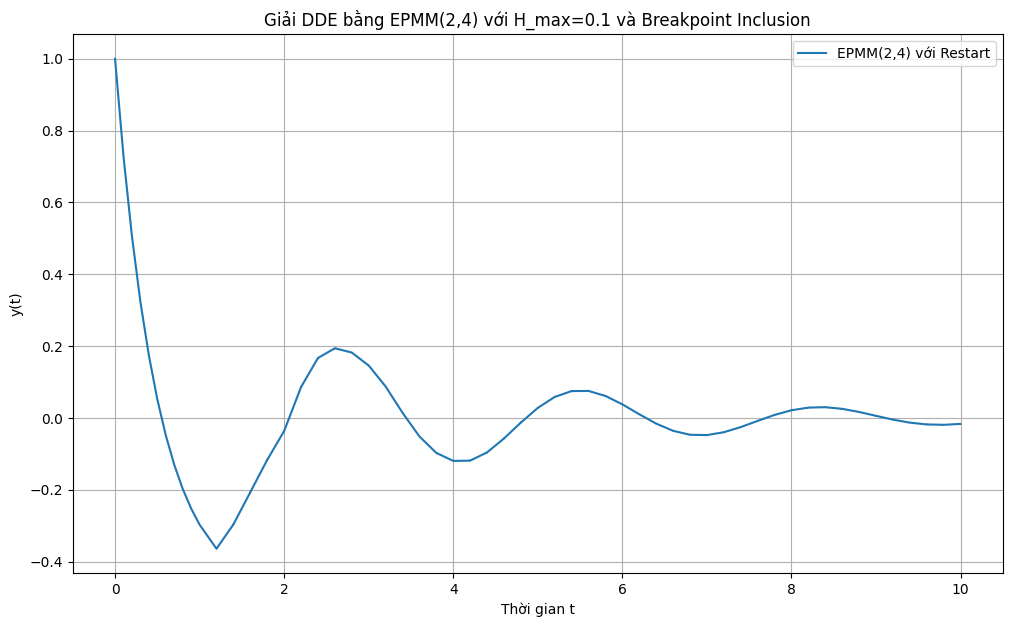

In [18]:
import numpy as np

# --- 1. HÀM NỘI SUY LAGRANGE ---
def lagrange_interpolate_general(t_target, known_ts, known_ys, num_points=4):
    n_known = len(known_ts)
    if n_known == 0: raise ValueError("Nội suy: không có điểm dữ liệu.")
    if not hasattr(known_ys, '__getitem__'): raise TypeError("known_ys phải là một dãy.")
    if len(known_ys) != n_known: raise ValueError("known_ts và known_ys phải cùng độ dài.")

    if n_known == 1: return known_ys[0]

    # Chọn điểm nội suy
    distances = np.abs(np.array(known_ts) - t_target)
    sorted_indices_by_dist = np.argsort(distances)
    num_points_to_use = min(n_known, num_points)
    selected_orig_indices = np.sort(sorted_indices_by_dist[:num_points_to_use])

    current_ts = np.array(known_ts)[selected_orig_indices]
    current_ys = np.array(known_ys)[selected_orig_indices]
    
    if not current_ts.size: # Nếu không chọn được điểm nào (rất hiếm)
        # Fallback: thử dùng điểm gần nhất nếu có
        if n_known > 0:
            closest_idx = np.argmin(np.abs(np.array(known_ts) - t_target))
            return known_ys[closest_idx]
        raise ValueError(f"Không thể chọn điểm nội suy cho t_target={t_target}")

    result = 0.0
    for i in range(len(current_ts)):
        term = current_ys[i]
        for j in range(len(current_ts)):
            if i == j: continue
            denominator = current_ts[i] - current_ts[j]
            if abs(denominator) < 1e-18: # Tránh chia cho 0
                if len(current_ts) == 1: return current_ys[0] # Should be caught earlier
                # print(f"Cảnh báo: Mẫu số nội suy quá nhỏ tại t={current_ts[i]}.")
                # Nếu mẫu số là 0, và tử số cũng là 0 (t_target == current_ts[j]), thì giới hạn là phức tạp
                # Nếu mẫu số là 0, và tử số khác 0, đây là vấn đề.
                # Bỏ qua số hạng này nếu các điểm trùng nhau.
                if abs(t_target - current_ts[j]) < 1e-18 : # Nếu t_target trùng với một điểm khác i
                     # và điểm đó cũng là điểm đang xét thì term phải là 1, nhưng logic này cho vòng ngoài
                     pass # Để term hiện tại
                else: # Mẫu số gần 0 nhưng tử số không, term sẽ rất lớn hoặc NaN
                     # Đây là dấu hiệu các điểm ts trùng nhau.
                     pass # Bỏ qua phép nhân này nếu các điểm ts trùng nhau.
                continue
            term *= (t_target - current_ts[j]) / denominator
        result += term
    return result

# --- 2. LỚP TRỢ GIÚP TRUY CẬP GIÁ TRỊ ---
class ValueAccessor:
    def __init__(self, t0, phi_hist_func, tau_func,
                 ts_solution_list_ref, ys_solution_dict_ref, # Tham chiếu
                 interpolation_func, num_interp_points):
        self.t0 = t0
        self.phi_hist = phi_hist_func
        self.tau_func = tau_func
        self.ts_sol = ts_solution_list_ref
        self.ys_sol = ys_solution_dict_ref
        self.interpolate = interpolation_func
        self.num_interp_points = num_interp_points

    def get_delayed_value(self, order_k, eval_time, current_t_for_tau, current_y_at_eval_time):
        actual_tau = self.tau_func(current_t_for_tau, current_y_at_eval_time)
        time_delayed = eval_time - actual_tau

        if time_delayed <= self.t0 + 1e-12: # Thêm một epsilon nhỏ để xử lý sai số float khi time_delayed rất gần t0
            return self.phi_hist(time_delayed, order=order_k)
        else:
            if order_k not in self.ys_sol or not self.ts_sol or len(self.ys_sol[order_k]) == 0:
                raise ValueError(f"Không có dữ liệu/list cho đạo hàm bậc {order_k} để nội suy.")

            # Chỉ nội suy trên các điểm đã được tính toán và không phải là None
            # Quan trọng: chỉ dùng các điểm có t <= eval_time để tránh "nhìn vào tương lai" khi nội suy
            # cho một giá trị trễ tại thời điểm eval_time.
            valid_indices = [
                i for i, t_comp in enumerate(self.ts_sol)
                if t_comp <= eval_time + 1e-12 and \
                   i < len(self.ys_sol[order_k]) and \
                   self.ys_sol[order_k][i] is not None
            ]
            
            if not valid_indices:
                # print(f"Cảnh báo nội suy: Không có điểm hợp lệ cho y^({order_k}) tại t_delayed={time_delayed:.4f} (eval_time={eval_time:.4f}). Dùng lịch sử.")
                return self.phi_hist(time_delayed, order=order_k)

            interp_ts = [self.ts_sol[i] for i in valid_indices]
            interp_ys_for_order_k = [self.ys_sol[order_k][i] for i in valid_indices]

            if not interp_ts: # Nếu rỗng sau khi lọc
                return self.phi_hist(time_delayed, order=order_k)
            
            return self.interpolate(time_delayed, interp_ts, interp_ys_for_order_k, self.num_interp_points)

# --- 3. HÀM RK4 CHO DDE (MỘT BƯỚC) ---
def rk4_dde_step_for_startup(f_dde_prime, t_start, y_start, h_actual, value_accessor_for_rk4):
    y_delayed_k1 = value_accessor_for_rk4.get_delayed_value(0, t_start, t_start, y_start)
    k1 = h_actual * f_dde_prime(t_start, y_start, y_delayed_k1)

    t_k23 = t_start + h_actual / 2
    y_k2_approx = y_start + k1 / 2
    y_delayed_k2 = value_accessor_for_rk4.get_delayed_value(0, t_k23, t_k23, y_k2_approx)
    k2 = h_actual * f_dde_prime(t_k23, y_k2_approx, y_delayed_k2)

    y_k3_approx = y_start + k2 / 2
    y_delayed_k3 = value_accessor_for_rk4.get_delayed_value(0, t_k23, t_k23, y_k3_approx)
    k3 = h_actual * f_dde_prime(t_k23, y_k3_approx, y_delayed_k3)

    t_k4 = t_start + h_actual
    y_k4_approx = y_start + k3
    y_delayed_k4 = value_accessor_for_rk4.get_delayed_value(0, t_k4, t_k4, y_k4_approx)
    k4 = h_actual * f_dde_prime(t_k4, y_k4_approx, y_delayed_k4)
    
    y_next = y_start + (k1 + 2*k2 + 2*k3 + k4) / 6
    return y_next

# --- 4. LỚP TÍCH HỢP DDE CHÍNH ---
class DDESolverEPMM24_Restart:
    def __init__(self, f_dde_prime_func, deriv_funcs_dict, tau_func, phi_hist_func, 
                 t_span, H_max_formula, num_interp_points=4):
        
        self.f_dde_prime = f_dde_prime_func
        self.deriv_funcs = deriv_funcs_dict
        if not all(k in self.deriv_funcs for k in [2,3,4]):
            raise ValueError("Cần cung cấp các hàm tính đạo hàm bậc 2, 3, và 4 trong deriv_funcs_dict.")

        self.tau_func = tau_func
        self.phi_hist = phi_hist_func
        self.t0, self.t_final = t_span
        self.H_max_formula_param = H_max_formula # Đây là 'H' trong tài liệu, bước nhảy EPMM là 2H.

        self.ts_sol = []
        self.ys_sol = {0: [], 1: [], 2: [], 3: []} # y, y', y'', y'''
        self.num_interp_points = num_interp_points

        # ValueAccessor được khởi tạo sau khi có điểm đầu tiên
        self.value_accessor = None
        self._initialize_solver()

    def _initialize_solver(self):
        print("Bắt đầu khởi tạo bộ giải...")
        self.ts_sol.append(self.t0)
        self.ys_sol[0].append(self.phi_hist(self.t0, order=0))
        for k in range(1, 4): self.ys_sol[k].append(None) # Chỗ cho đạo hàm

        # Tạo ValueAccessor sau khi có điểm t0
        self.value_accessor = ValueAccessor(self.t0, self.phi_hist, self.tau_func,
                                            self.ts_sol, self.ys_sol, # Truyền tham chiếu
                                            lagrange_interpolate_general, self.num_interp_points)

        # Tính đạo hàm tại t0
        print(f"Tính đạo hàm tại t0 = {self.t0:.4f}")
        self._calculate_and_store_all_derivatives_at_idx(0) # idx_n = 0

        if abs(self.t0 - self.t_final) < 1e-9: # Nếu chỉ giải tại một điểm
            print("t0 trùng t_final. Khởi tạo hoàn tất.")
            return

        # Xác định breakpoint đầu tiên và bước RK4 đầu tiên
        y0_val = self.ys_sol[0][0]
        tau_at_t0 = self.tau_func(self.t0, y0_val)
        first_breakpoint_val = self.t0 + tau_at_t0 if tau_at_t0 > 1e-12 else float('inf')

        # h_rk4_eff là bước nhảy của RK4, nên <= H_max_formula_param
        # và cũng không nên nhảy qua breakpoint hoặc t_final
        h_rk4_eff = min(self.H_max_formula_param, 
                        (first_breakpoint_val - self.t0) if first_breakpoint_val > self.t0 + 1e-12 else self.H_max_formula_param,
                        self.t_final - self.t0)
        
        if h_rk4_eff < 1e-12 :
            print("Khoảng thời gian quá nhỏ hoặc t0 trùng breakpoint/t_final sớm. Không cần bước RK4.")
        else:
            t1_val = self.t0 + h_rk4_eff
            print(f"Tính y1 tại t1={t1_val:.4f} bằng RK4 với h_rk4={h_rk4_eff:.4f}...")
            y1_val = rk4_dde_step_for_startup(self.f_dde_prime, self.t0, y0_val, h_rk4_eff, self.value_accessor)
            
            self.ts_sol.append(t1_val)
            self.ys_sol[0].append(y1_val)
            for k in range(1, 4): self.ys_sol[k].append(None)
            
            print(f"Tính đạo hàm tại t1 = {t1_val:.4f}")
            self._calculate_and_store_all_derivatives_at_idx(1) # idx_n = 1
        
        print(f"Khởi tạo hoàn tất. Có {len(self.ts_sol)} điểm: {self.ts_sol}")


    def _calculate_and_store_all_derivatives_at_idx(self, idx_n):
        t_n = self.ts_sol[idx_n]
        y_n = self.ys_sol[0][idx_n]
        if y_n is None: raise ValueError(f"y_n là None tại idx {idx_n}.")

        derivatives = {}
        y_delayed_for_yp = self.value_accessor.get_delayed_value(0, t_n, t_n, y_n)
        derivatives[1] = self.f_dde_prime(t_n, y_n, y_delayed_for_yp)
        
        # Sử dụng các hàm do người dùng cung cấp cho đạo hàm bậc cao
        derivatives[2] = self.deriv_funcs[2](t_n, y_n, derivatives[1], self.value_accessor)
        derivatives[3] = self.deriv_funcs[3](t_n, y_n, derivatives[1], derivatives[2], self.value_accessor)
        derivatives[4] = self.deriv_funcs[4](t_n, y_n, derivatives[1], derivatives[2], derivatives[3], self.value_accessor)

        for k_ord in range(1, 4): # Lưu y', y'', y'''
            self.ys_sol[k_ord][idx_n] = derivatives[k_ord]
            if derivatives[k_ord] is None: # Kiểm tra quan trọng
                raise ValueError(f"Tính toán đạo hàm bậc {k_ord} tại t={t_n:.4f} trả về None.")
        if derivatives[4] is None:
             raise ValueError(f"Tính toán đạo hàm bậc 4 tại t={t_n:.4f} trả về None.")
        return derivatives # Trả về cả 4 đạo hàm


    def solve(self):
        if len(self.ts_sol) < 2:
            if not self.ts_sol or abs(self.ts_sol[0] - self.t_final) > 1e-9 : # Nếu chưa tới t_final
                 print("Cảnh báo: Không đủ điểm khởi tạo (cần ít nhất 2) để bắt đầu EPMM.")
                 # Có thể thử thêm một bước RK4 nữa nếu chỉ có t0
                 if len(self.ts_sol) == 1 and self.ts_sol[0] < self.t_final - 1e-9:
                    h_next_rk4 = min(self.H_max_formula_param, self.t_final - self.ts_sol[0])
                    if h_next_rk4 > 1e-12:
                        y_next_val = rk4_dde_step_for_startup(self.f_dde_prime, self.ts_sol[0], self.ys_sol[0][0], h_next_rk4, self.value_accessor)
                        self.ts_sol.append(self.ts_sol[0] + h_next_rk4)
                        self.ys_sol[0].append(y_next_val)
                        for k_init_deriv in range(1, 4): self.ys_sol[k_init_deriv].append(None)
                        self._calculate_and_store_all_derivatives_at_idx(1)
                        if len(self.ts_sol) < 2: # Vẫn không đủ
                            return self.ts_sol, self.ys_sol[0] # Trả về những gì có
                    else:
                        return self.ts_sol, self.ys_sol[0]

            else: # Chỉ có t0 và t0 = t_final
                return self.ts_sol, self.ys_sol[0]


        current_n_idx = 0 # Chỉ số của y_n trong công thức EPMM
        
        while True:
            t_n = self.ts_sol[current_n_idx]
            # Kiểm tra điều kiện dừng sớm
            if t_n >= self.t_final - 1e-9: break
            if current_n_idx + 1 >= len(self.ts_sol): # Không còn điểm y_{n+1} để làm cơ sở nhảy
                break 

            y_n = self.ys_sol[0][current_n_idx]
            if y_n is None: break # Lỗi logic

            # 1. Xác định breakpoint tiếp theo
            # tau_at_tn = self.tau_func(t_n, y_n) # Dùng tau tại điểm hiện tại để dự đoán breakpoint
            # next_breakpoint = float('inf')
            # if tau_at_tn > 1e-12:
            #     # Tìm k nhỏ nhất sao cho self.t0 + k*tau_at_tn > t_n (cách đơn giản)
            #     # Cần một cách mạnh mẽ hơn để theo dõi các breakpoint thực sự
            #     num_taus_from_t0 = (t_n - self.t0) / tau_at_tn if tau_at_tn > 0 else float('inf')
            #     k_next_bk = np.floor(num_taus_from_t0) + 1
            #     # Kiểm tra lại k_next_bk này có thực sự sau t_n không
            #     # if self.t0 + k_next_bk * tau_at_tn <= t_n + 1e-12 : k_next_bk +=1
            #     # Tạm thời dùng cách đơn giản hơn: breakpoint tiếp theo là bội số của tau_at_t0 tính từ t0
            #     # Điều này chỉ đúng nếu tau không đổi từ t0. Cần cải thiện cho tau biến thiên.
            #     # Cách an toàn hơn: tìm breakpoint tiếp theo bằng cách theo dõi các điểm t_sol[i] + tau(t_sol[i], y_sol[i])
            #     # For now, a simpler strategy for constant/slowly varying tau for breakpoint targeting:
            #     # The "next actual breakpoint" is the first t0 + k*tau_initial > t_n
            tau_initial = self.tau_func(self.t0, self.ys_sol[0][0]) # Ước lượng tau ban đầu
            if tau_initial > 1e-12:
                k = 0; bk = self.t0
                while bk <= t_n + 1e-12: # Tìm bk đầu tiên > t_n
                    k += 1
                    bk = self.t0 + k * tau_initial
                    if k > 2 * len(self.ts_sol) + 100: break # Ngăn lặp vô hạn
                next_breakpoint = bk
            else: # Không có trễ hoặc trễ quá nhỏ
                next_breakpoint = float('inf')


            # 2. Xác định t_{n+2} (điểm đích của bước nhảy EPMM)
            target_t_max_jump = t_n + 2 * self.H_max_formula_param
            t_target_n_plus_2 = min(target_t_max_jump, next_breakpoint, self.t_final)

            # 3. Tính h_eff
            if t_target_n_plus_2 <= t_n + 1e-12: # Không thể tiến thêm
                break
            
            h_eff = (t_target_n_plus_2 - t_n) / 2.0

            if h_eff < 1e-12: # Bước quá nhỏ
                # print(f"Cảnh báo: h_eff ({h_eff:.2e}) quá nhỏ tại t_n={t_n:.4f}. Chuyển sang điểm n tiếp theo.")
                # current_n_idx += 1 # Thử bỏ qua và dùng điểm n tiếp theo
                # if current_n_idx +1 >= len(self.ts_sol): break
                # continue
                break # Dừng nếu bước quá nhỏ để tránh lỗi


            # 4. Lấy các đạo hàm đã tính tại t_n
            # Chúng phải được tính ở cuối vòng lặp trước hoặc trong khởi tạo
            derivatives_at_tn = {
                1: self.ys_sol[1][current_n_idx],
                2: self.ys_sol[2][current_n_idx],
                3: self.ys_sol[3][current_n_idx],
                4: self.deriv_funcs[4](t_n, y_n, 
                                       self.ys_sol[1][current_n_idx], 
                                       self.ys_sol[2][current_n_idx], 
                                       self.ys_sol[3][current_n_idx], 
                                       self.value_accessor)
            }
            if any(d is None for d in derivatives_at_tn.values()):
                # Nếu một đạo hàm nào đó chưa được tính, tính ngay bây giờ
                # print(f"Tính lại đạo hàm on-the-fly cho t_n={t_n} (idx={current_n_idx})")
                temp_derivatives = self._calculate_and_store_all_derivatives_at_idx(current_n_idx)
                derivatives_at_tn = {k: temp_derivatives.get(k, None) for k in range(1,5)}
                if any(d is None for d in derivatives_at_tn.values()):
                     raise ValueError(f"Không thể lấy đủ đạo hàm tại t_n={t_n} cho bước EPMM.")

            # 5. Áp dụng công thức EPMM(2,4)
            y_n_plus_2_val = (
                y_n +
                2 * h_eff * derivatives_at_tn[1] +
                2 * h_eff**2 * derivatives_at_tn[2] +
                (4/3) * h_eff**3 * derivatives_at_tn[3] +
                (2/3) * h_eff**4 * derivatives_at_tn[4]
            )
            
            # 6. Lưu trữ kết quả t_{n+2}, y_{n+2}
            idx_n_plus_2 = current_n_idx + 2
            
            # Đảm bảo self.ts_sol và self.ys_sol đủ dài
            while len(self.ts_sol) <= idx_n_plus_2:
                self.ts_sol.append(0.0) # Giá trị tạm, sẽ được ghi đè
                for k_list in range(4): self.ys_sol[k_list].append(None)

            self.ts_sol[idx_n_plus_2] = t_target_n_plus_2 # Chính là t_n + 2*h_eff
            self.ys_sol[0][idx_n_plus_2] = y_n_plus_2_val
            
            # 7. Tính đạo hàm cho các điểm "mới" (t_{n+1} và t_{n+2}) để chuẩn bị cho bước sau
            #    hoặc cho nội suy.
            #    t_{n+1} là self.ts_sol[current_n_idx + 1]
            #    t_{n+2} là self.ts_sol[current_n_idx + 2]
            #    Đảm bảo các đạo hàm này được tính nếu chúng chưa có.
            idx_n_plus_1 = current_n_idx + 1
            if idx_n_plus_1 < len(self.ts_sol): # Điểm t_{n+1} phải tồn tại (từ RK4 hoặc bước EPMM trước đó)
                if self.ys_sol[1][idx_n_plus_1] is None: # Chỉ tính nếu chưa có
                    # print(f"Tính đạo hàm cho điểm t_{n+1} (idx={idx_n_plus_1})")
                    self._calculate_and_store_all_derivatives_at_idx(idx_n_plus_1)
            
            if self.ys_sol[1][idx_n_plus_2] is None: # Chỉ tính nếu chưa có (cho điểm vừa thêm)
                # print(f"Tính đạo hàm cho điểm t_{n+2} (idx={idx_n_plus_2})")
                self._calculate_and_store_all_derivatives_at_idx(idx_n_plus_2)

            current_n_idx += 1 # Chuyển sang điểm cơ sở tiếp theo cho EPMM

        return self.ts_sol, self.ys_sol[0]


# --- 5. VÍ DỤ SỬ DỤNG (giống như trước) ---
if __name__ == '__main__':
    print("--- Ví dụ giải DDE bằng EPMM(2,4) với chiến lược Breakpoint Inclusion (v2) ---")

    # --- A. Người dùng định nghĩa các hàm ---
    def dde_ex_f_prime(t, y_val, y_delayed_val):
        return -2 * y_val - y_delayed_val

    def dde_ex_tau_func(t, y_val):
        return 1.0 

    def dde_ex_phi_hist(t, order=0):
        if order == 0: return 1.0 
        return 0.0 

    def dde_ex_ypp(t, y, yp, acc): 
        yp_delayed = acc.get_delayed_value(1, t, t, y) 
        return -2 * yp - yp_delayed

    def dde_ex_yppp(t, y, yp, ypp, acc):
        ypp_delayed = acc.get_delayed_value(2, t, t, y) 
        return -2 * ypp - ypp_delayed

    def dde_ex_ypppp(t, y, yp, ypp, yppp, acc):
        yppp_delayed = acc.get_delayed_value(3, t, t, y) 
        return -2 * yppp - yppp_delayed

    analytical_deriv_funcs_main = {
        2: dde_ex_ypp, 3: dde_ex_yppp, 4: dde_ex_ypppp,
    }

    t_start_main = 0.0
    t_end_main = 10.0 
    H_max_formula_val_main = 0.1 # => bước nhảy EPMM tối đa là 0.1

    print(f"Đang giải DDE: y'(t) = -2y(t) - y(t-1)")
    print(f"Lịch sử: y(t<=0) = 1, Trễ tau = 1.0")
    print(f"Khoảng thời gian: [{t_start_main}, {t_end_main}], H_max (cho công thức EPMM) = {H_max_formula_val_main}")
    
    integrator = DDESolverEPMM24_Restart(
            f_dde_prime_func=dde_ex_f_prime,
            deriv_funcs_dict=analytical_deriv_funcs_main,
            tau_func=dde_ex_tau_func,
            phi_hist_func=dde_ex_phi_hist,
            t_span=(t_start_main, t_end_main),
            H_max_formula=H_max_formula_val_main,
            num_interp_points=4
        )
    

    final_times, final_y_solution = integrator.solve()

    print("\n--- Kết quả cuối cùng ---")
    indices_to_print = [i for i in range(0, len(final_times), max(1, len(final_times) // 20))]
    for i in indices_to_print:
        y_val_print = final_y_solution[i] if final_y_solution[i] is not None else float('nan')
        print(f"t = {final_times[i]:.4f}, y(t) = {y_val_print:.8f}")

    try:
        import matplotlib.pyplot as plt
        # Lọc bỏ các điểm None nếu có trước khi vẽ
        plot_times = [final_times[i] for i, yval in enumerate(final_y_solution) if yval is not None]
        plot_ys = [yval for yval in final_y_solution if yval is not None]

        if plot_times: # Chỉ vẽ nếu có dữ liệu
            plt.figure(figsize=(12, 7))
            plt.plot(plot_times, plot_ys, linestyle='-', label='EPMM(2,4) với Restart')
            plt.xlabel('Thời gian t'); plt.ylabel('y(t)')
            plt.title(f'Giải DDE bằng EPMM(2,4) với H_max={H_max_formula_val_main} và Breakpoint Inclusion')
            plt.legend(); plt.grid(True); plt.show()
        else:
            print("Không có dữ liệu hợp lệ để vẽ đồ thị.")
    except ImportError:
        print("\nThư viện matplotlib chưa được cài đặt.")
    except Exception as e:
        print(f"Lỗi khi vẽ đồ thị: {e}")